In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import sklearn.model_selection
import pandas as pd
import pylab
import sys
import seaborn as sns
import statsmodels.formula.api as smf
from scipy import stats
from pySuStaIn import ZscoreSustain

import mrmr



c:\Users\huw\OneDrive\Documents\Research_Internship\MPhys_scripts\.conda\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


dx_map = {
    'AD': 0,
    'Dementia': 0,
    'MCI': 1,
    'EMCI': 1,
    'LMCI': 1,
    'CN': 2,
    'SMC': 2
}

In [95]:
data_dir = 'data'

df = pd.read_csv(os.path.join(data_dir, 'huw_whole_df.csv'), index_col = 0)

dx_map = {
    0: 0,
    1 : 1,
    2 : 2,
    3 : 2,
}


df['DX_bl'] = df['DX_bl'].map(dx_map)

df['DX_bl'].value_counts()

df

,PTID,TAU_bl,PTAU_bl,ABETA_bl,EXAMDATE,EXAMDATE_bl,DX_bl,DX,AGE,PTGENDER,...,SUVr_Vermis_1_2.nii,SUVr_Vermis_3.nii,SUVr_Vermis_4_5.nii,SUVr_Vermis_6.nii,SUVr_Vermis_7.nii,SUVr_Vermis_8.nii,SUVr_Vermis_9.nii,SUVr_Vermis_10.nii,SUVr_VTA_L.nii,SUVr_VTA_R.nii
1,100_S_5280,101.20,10.08,731.8,2015-09-29,2013-09-17,2,2,67.5,0,...,0.003369,0.011351,0.030880,0.018253,0.009289,0.011917,0.008881,0.006231,0.000712,0.000659
2,027_S_5277,324.80,34.39,780.3,2015-08-31,2013-08-28,2,2,71.8,1,...,0.003325,0.011246,0.029007,0.016903,0.009108,0.012666,0.008033,0.006029,0.000770,0.000699
3,135_S_5275,490.40,53.18,832.7,2014-02-25,2013-08-27,0,0,78.0,1,...,0.003402,0.011694,0.033622,0.019224,0.010413,0.012902,0.007799,0.005730,0.000804,0.000760
4,135_S_5269,108.20,10.55,590.4,2015-09-01,2013-08-20,2,2,64.9,0,...,0.003367,0.011986,0.034076,0.019834,0.010011,0.012782,0.009789,0.006613,0.000748,0.000675
5,007_S_5265,247.10,24.78,466.1,2015-08-25,2013-08-12,2,2,75.1,1,...,0.002935,0.009448,0.028740,0.017897,0.009361,0.012595,0.008533,0.005170,0.000675,0.000675
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
542,127_S_5266,279.90,24.28,1700.0,2015-08-06,2013-08-15,2,2,65.9,0,...,0.003873,0.012135,0.034131,0.018864,0.008398,0.011478,0.009674,0.007555,0.000818,0.000764
543,053_S_5272,305.00,25.05,1700.0,2015-09-15,2013-09-04,2,2,69.9,1,...,0.003308,0.010313,0.029413,0.016943,0.008936,0.011930,0.008579,0.006243,0.000678,0.000581
544,053_S_5287,268.40,26.11,1700.0,2015-09-30,2013-09-18,2,2,78.9,1,...,0.003723,0.011469,0.026939,0.015693,0.008374,0.011329,0.008016,0.006976,0.000753,0.000723
545,027_S_5288,300.10,26.59,1700.0,2015-09-24,2013-09-25,2,2,81.9,1,...,0.003486,0.011536,0.031103,0.017387,0.008620,0.010525,0.007063,0.005713,0.000815,0.000768


we need a control group from which we are going to calculate the z-scroes for. We will use anyone with an ABETA_bl of 1700. To identify them as a control group we will set their DX_bl to 3.

In [96]:
df.loc[(df['ABETA_bl'] == 1700) & (df['DX_bl'] == 2), 'DX_bl'] = 3


df_1 = df.drop(columns=['PTEDUCAT','TAU_bl','PTAU_bl','ABETA_bl', 'MMSE_bl','EcogPtTotal_bl', 'LDELTOTAL_BL', 'mPACCdigit_bl', 'mPACCtrailsB_bl', 'RAVLT_immediate_bl', 'RAVLT_learning_bl', 'RAVLT_forgetting_bl','PTID', 'EXAMDATE', 'EXAMDATE_bl', 'DX','AGE', 'PTGENDER', 'PTRACCAT', 'FHQMOM', 'FHQDAD', 'FHQMOMAD', 'FHQDADAD', 'RAVLT_perc_forgetting_bl'])

df_1

,DX_bl,SUVr_ACC_pre_L.nii,SUVr_ACC_pre_R.nii,SUVr_ACC_sub_L.nii,SUVr_ACC_sub_R.nii,SUVr_ACC_sup_L.nii,SUVr_ACC_sup_R.nii,SUVr_Amygdala_L.nii,SUVr_Amygdala_R.nii,SUVr_Angular_L.nii,...,SUVr_Vermis_1_2.nii,SUVr_Vermis_3.nii,SUVr_Vermis_4_5.nii,SUVr_Vermis_6.nii,SUVr_Vermis_7.nii,SUVr_Vermis_8.nii,SUVr_Vermis_9.nii,SUVr_Vermis_10.nii,SUVr_VTA_L.nii,SUVr_VTA_R.nii
1,2,0.033800,0.042295,0.010627,0.008586,0.039320,0.038841,0.011054,0.014155,0.058692,...,0.003369,0.011351,0.030880,0.018253,0.009289,0.011917,0.008881,0.006231,0.000712,0.000659
2,2,0.056520,0.063619,0.016490,0.012617,0.057261,0.053242,0.013008,0.017184,0.108759,...,0.003325,0.011246,0.029007,0.016903,0.009108,0.012666,0.008033,0.006029,0.000770,0.000699
3,0,0.060682,0.068784,0.017864,0.013864,0.054272,0.053113,0.013620,0.016730,0.104904,...,0.003402,0.011694,0.033622,0.019224,0.010413,0.012902,0.007799,0.005730,0.000804,0.000760
4,2,0.042112,0.049571,0.011925,0.010232,0.044834,0.042373,0.011938,0.015462,0.067635,...,0.003367,0.011986,0.034076,0.019834,0.010011,0.012782,0.009789,0.006613,0.000748,0.000675
5,2,0.041158,0.046395,0.012714,0.009992,0.042674,0.039067,0.011457,0.013684,0.073826,...,0.002935,0.009448,0.028740,0.017897,0.009361,0.012595,0.008533,0.005170,0.000675,0.000675
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
542,3,0.044351,0.052593,0.011514,0.010009,0.042117,0.045545,0.013725,0.016478,0.062204,...,0.003873,0.012135,0.034131,0.018864,0.008398,0.011478,0.009674,0.007555,0.000818,0.000764
543,3,0.036909,0.047695,0.011225,0.008871,0.040523,0.041999,0.011000,0.014486,0.076857,...,0.003308,0.010313,0.029413,0.016943,0.008936,0.011930,0.008579,0.006243,0.000678,0.000581
544,3,0.038544,0.048572,0.012500,0.010097,0.046125,0.047444,0.010035,0.012790,0.074429,...,0.003723,0.011469,0.026939,0.015693,0.008374,0.011329,0.008016,0.006976,0.000753,0.000723
545,3,0.029956,0.041714,0.009979,0.008269,0.035993,0.039143,0.010660,0.014074,0.065539,...,0.003486,0.011536,0.031103,0.017387,0.008620,0.010525,0.007063,0.005713,0.000815,0.000768


In [300]:
df[df['DX_bl'] == 3]

,PTID,TAU_bl,PTAU_bl,ABETA_bl,EXAMDATE,EXAMDATE_bl,DX_bl,DX,AGE,PTGENDER,...,SUVr_Vermis_1_2.nii,SUVr_Vermis_3.nii,SUVr_Vermis_4_5.nii,SUVr_Vermis_6.nii,SUVr_Vermis_7.nii,SUVr_Vermis_8.nii,SUVr_Vermis_9.nii,SUVr_Vermis_10.nii,SUVr_VTA_L.nii,SUVr_VTA_R.nii
448,098_S_4018,238.6,22.26,1700.0,2013-05-06,2011-05-25,3,2,76.1,0,...,0.003106,0.011238,0.030678,0.017396,0.008009,0.012278,0.008586,0.005417,0.000808,0.000766
449,023_S_4020,265.0,24.15,1700.0,2013-06-10,2011-06-22,3,2,66.5,0,...,0.003559,0.011306,0.029387,0.017100,0.008130,0.013205,0.009152,0.006151,0.000900,0.000870
450,037_S_4028,308.2,23.95,1700.0,2013-05-07,2011-05-23,3,2,63.5,1,...,0.003719,0.013382,0.035322,0.019974,0.010522,0.012777,0.008201,0.005894,0.000834,0.000732
451,041_S_4037,210.1,17.76,1700.0,2013-06-03,2011-06-03,3,2,75.6,0,...,0.003632,0.011659,0.034022,0.017100,0.007375,0.010670,0.009482,0.006651,0.000835,0.000696
452,041_S_4041,377.9,30.42,1700.0,2013-05-13,2011-06-08,3,0,77.9,1,...,0.003817,0.012380,0.031569,0.017693,0.008476,0.012119,0.010259,0.007498,0.000810,0.000726
453,116_S_4043,263.9,21.98,1700.0,2013-06-13,2011-05-31,3,2,82.1,0,...,0.003644,0.011285,0.029665,0.016884,0.008699,0.011934,0.008684,0.006279,0.000771,0.000687
454,011_S_4075,298.2,25.94,1700.0,2013-06-06,2011-06-20,3,2,73.4,0,...,0.004013,0.012679,0.032921,0.019261,0.009712,0.013593,0.009574,0.007387,0.000816,0.000709
455,024_S_4084,237.6,20.67,1700.0,2013-07-12,2011-07-20,3,2,68.4,1,...,0.003822,0.011772,0.030514,0.017691,0.008667,0.011573,0.008892,0.006450,0.000857,0.000709
458,003_S_4119,305.6,30.31,1700.0,2013-07-31,2011-08-18,3,2,79.3,0,...,0.003989,0.012134,0.028108,0.017397,0.007674,0.011629,0.008259,0.006747,0.001000,0.000875
461,006_S_4150,227.0,19.39,1700.0,2013-09-10,2011-09-01,3,2,73.9,0,...,0.004088,0.013104,0.029854,0.019475,0.010109,0.012517,0.008446,0.007043,0.000889,0.000835


In [246]:
features = mrmr.mrmr_classif(df_1.drop(columns=['DX_bl']), df_1['DX_bl'], K = 10)
features


100%|██████████| 10/10 [00:00<00:00, 20.13it/s]


['SUVr_Precuneus_L.nii',
 'SUVr_Thal_AV_R.nii',
 'SUVr_Lingual_L.nii',
 'SUVr_Precuneus_R.nii',
 'SUVr_Calcarine_L.nii',
 'SUVr_Fusiform_L.nii',
 'SUVr_Thal_AV_L.nii',
 'SUVr_Parietal_Sup_L.nii',
 'SUVr_Fusiform_R.nii',
 'SUVr_Angular_L.nii']

In [247]:
features = features + ['TAU_bl', 'PTAU_bl']

In [248]:
features

['SUVr_Precuneus_L.nii',
 'SUVr_Thal_AV_R.nii',
 'SUVr_Lingual_L.nii',
 'SUVr_Precuneus_R.nii',
 'SUVr_Calcarine_L.nii',
 'SUVr_Fusiform_L.nii',
 'SUVr_Thal_AV_L.nii',
 'SUVr_Parietal_Sup_L.nii',
 'SUVr_Fusiform_R.nii',
 'SUVr_Angular_L.nii',
 'TAU_bl',
 'PTAU_bl']

<Axes: xlabel='AGE', ylabel='TAU_bl'>

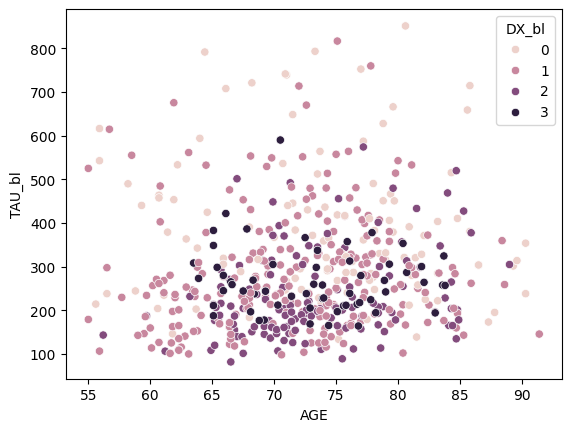

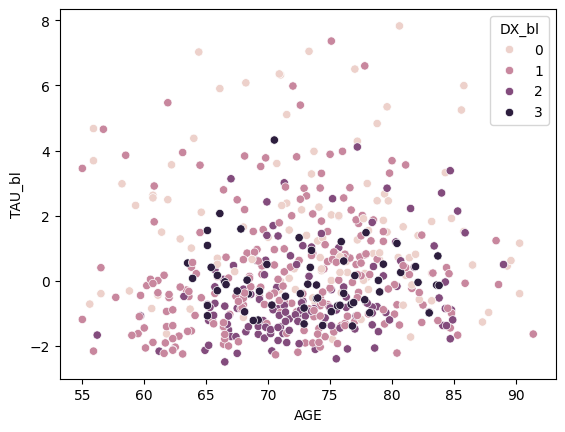

In [249]:
biomarkers_df = pd.DataFrame(df, copy=True)

suvr_cols = [col for col in biomarkers_df.columns if col.startswith("SUVr")] + ['TAU_bl', 'PTAU_bl']


for biomarker in suvr_cols:
    mean = biomarkers_df[biomarkers_df.DX_bl == 3][biomarker].mean()
    std = biomarkers_df[biomarkers_df.DX_bl == 3][biomarker].std()
    w_score = (df.loc[:,biomarker] - mean) / std
    
    biomarkers_df.loc[:,biomarker] = w_score

plt.figure(0)
sns.scatterplot(x=df.AGE,y=df['TAU_bl'],hue=df.DX_bl)
plt.figure(1)
sns.scatterplot(x=biomarkers_df.AGE,y=biomarkers_df['TAU_bl'],hue=biomarkers_df.DX_bl)

    

In [250]:
biomarkers_df

,PTID,TAU_bl,PTAU_bl,ABETA_bl,EXAMDATE,EXAMDATE_bl,DX_bl,DX,AGE,PTGENDER,...,SUVr_Vermis_1_2.nii,SUVr_Vermis_3.nii,SUVr_Vermis_4_5.nii,SUVr_Vermis_6.nii,SUVr_Vermis_7.nii,SUVr_Vermis_8.nii,SUVr_Vermis_9.nii,SUVr_Vermis_10.nii,SUVr_VTA_L.nii,SUVr_VTA_R.nii
1,100_S_5280,-2.233807,-1.955737,731.8,2015-09-29,2013-09-17,2,2,67.5,0,...,-0.747962,-0.359994,-0.133494,0.359815,0.628865,0.023323,0.259658,-0.306130,-1.147140,-1.018268
2,027_S_5277,0.765378,1.577642,780.3,2015-08-31,2013-08-28,2,2,71.8,1,...,-0.867301,-0.447348,-0.817488,-0.731646,0.407768,0.765470,-0.772522,-0.603690,-0.466361,-0.509310
3,135_S_5275,2.986599,4.308707,832.7,2014-02-25,2013-08-27,0,0,78.0,1,...,-0.660229,-0.074435,0.868304,1.144980,2.002364,0.999411,-1.058055,-1.043347,-0.071741,0.279041
4,135_S_5269,-2.139915,-1.887424,590.4,2015-09-01,2013-08-20,2,2,64.9,0,...,-0.754525,0.167895,1.034311,1.638702,1.511587,0.880901,1.365481,0.256133,-0.724118,-0.812586
5,007_S_5265,-0.276825,0.180860,466.1,2015-08-25,2013-08-12,2,2,75.1,1,...,-1.907838,-1.942887,-0.914967,0.072086,0.717472,0.695861,-0.164410,-1.866826,-1.578615,-0.821609
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
542,127_S_5266,0.163126,0.108186,1700.0,2015-08-06,2013-08-15,3,2,65.9,0,...,0.599696,0.292218,1.054211,0.854009,-0.459838,-0.412717,1.225569,1.640913,0.089042,0.328973
543,053_S_5272,0.499797,0.220103,1700.0,2015-09-15,2013-09-04,3,2,69.9,1,...,-0.913305,-1.223243,-0.669194,-0.698880,0.198078,0.035888,-0.107575,-0.288091,-1.545589,-2.028012
544,053_S_5287,0.008875,0.374171,1700.0,2015-09-30,2013-09-18,3,2,78.9,1,...,0.196173,-0.262271,-1.573092,-1.710013,-0.489649,-0.559652,-0.793930,0.790034,-0.670757,-0.191895
545,027_S_5288,0.434072,0.443937,1700.0,2015-09-24,2013-09-25,3,2,81.9,1,...,-0.434879,-0.206129,-0.051822,-0.340436,-0.188068,-1.357279,-1.953986,-1.068054,0.049923,0.386135


In [251]:
# N = len(suvr_cols[:3])         # number of biomarkers
N = len(features)

# SuStaInLabels = suvr_cols[:3]
SuStaInLabels = features


Z_vals = np.array([[1,2,3]]*N)     # Z-scores for each biomarker
Z_max  = np.array([5]*N)      

In [252]:
print(len(Z_vals))

12


In [253]:
# Input the settings for z-score SuStaIn
# To make the tutorial run faster I've set 
# N_startpoints = 10 and N_iterations_MCMC = int(1e4)
# I recommend using N_startpoints = 25 and 
# N_iterations_MCMC = int(1e5) or int(1e6) in general though

N_startpoints = 10
N_S_max = 3
N_iterations_MCMC = int(1e4)
output_folder = os.path.join(os.getcwd(), '12feats_csf')
dataset_name = '12feats_csf'

# Initiate the SuStaIn object
sustain_input = ZscoreSustain(
                              # biomarkers_df[suvr_cols[:3]].values,
                              biomarkers_df[features].values,
                              Z_vals,
                              Z_max,
                              SuStaInLabels,
                              N_startpoints,
                              N_S_max, 
                              N_iterations_MCMC, 
                              output_folder, 
                              dataset_name, 
                              False)

In [254]:
if not os.path.isdir(output_folder):
    os.mkdir(output_folder)

In [255]:
print("Z_vals.shape:", Z_vals.shape)
print("sustain_input.stage_biomarker_index.shape:", sustain_input.stage_biomarker_index.shape)



Z_vals.shape: (12, 3)
sustain_input.stage_biomarker_index.shape: (1, 36)


import shutil
shutil.rmtree(os.path.join(output_folder, 'pickle_files'), ignore_errors=True)

In [256]:
samples_sequence,   \
samples_f,          \
ml_subtype,         \
prob_ml_subtype,    \
ml_stage,           \
prob_ml_stage,      \
prob_subtype_stage  = sustain_input.run_sustain_algorithm()

Found pickle file: c:\Users\huw\OneDrive\Documents\Research_Internship\adni-ml\12feats_csf\pickle_files\12feats_csf_subtype0.pickle. Using pickled variables for 0 subtype.
Found pickle file: c:\Users\huw\OneDrive\Documents\Research_Internship\adni-ml\12feats_csf\pickle_files\12feats_csf_subtype1.pickle. Using pickled variables for 1 subtype.
Found pickle file: c:\Users\huw\OneDrive\Documents\Research_Internship\adni-ml\12feats_csf\pickle_files\12feats_csf_subtype2.pickle. Using pickled variables for 2 subtype.


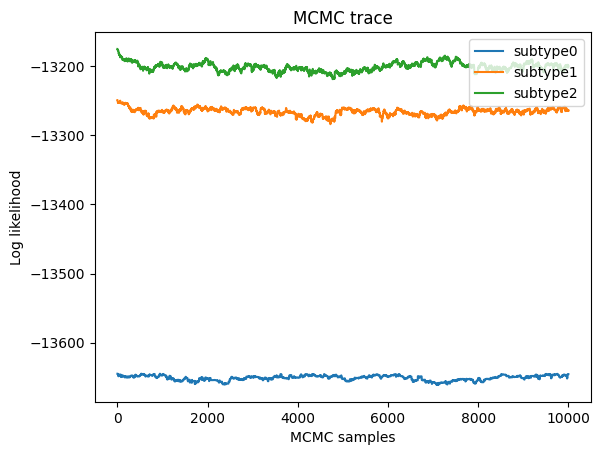

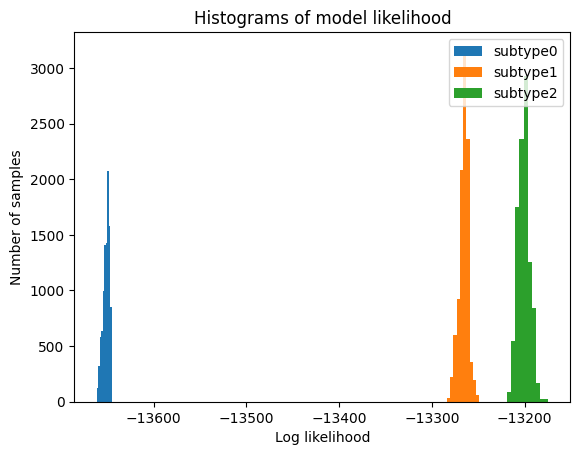

In [257]:
for s in range(N_S_max):
    # load pickle file (SuStaIn output) and get the sample log likelihood values
    pickle_filename_s = output_folder + '/pickle_files/' + dataset_name + '_subtype' + str(s) + '.pickle'
    pk = pd.read_pickle(pickle_filename_s)
    samples_likelihood = pk["samples_likelihood"]
    
    # plot the values as a line plot
    plt.figure(0)
    plt.plot(range(N_iterations_MCMC), samples_likelihood, label="subtype" + str(s))
    plt.legend(loc='upper right')
    plt.xlabel('MCMC samples')
    plt.ylabel('Log likelihood')
    plt.title('MCMC trace')
    
    # plot the values as a histogramp plot
    plt.figure(1)
    plt.hist(samples_likelihood, label="subtype" + str(s))
    plt.legend(loc='upper right')
    plt.xlabel('Log likelihood')  
    plt.ylabel('Number of samples')  
    plt.title('Histograms of model likelihood')

Loading pickle file: c:\Users\huw\OneDrive\Documents\Research_Internship\adni-ml\12feats_csf/pickle_files/12feats_csf_subtype2.pickle


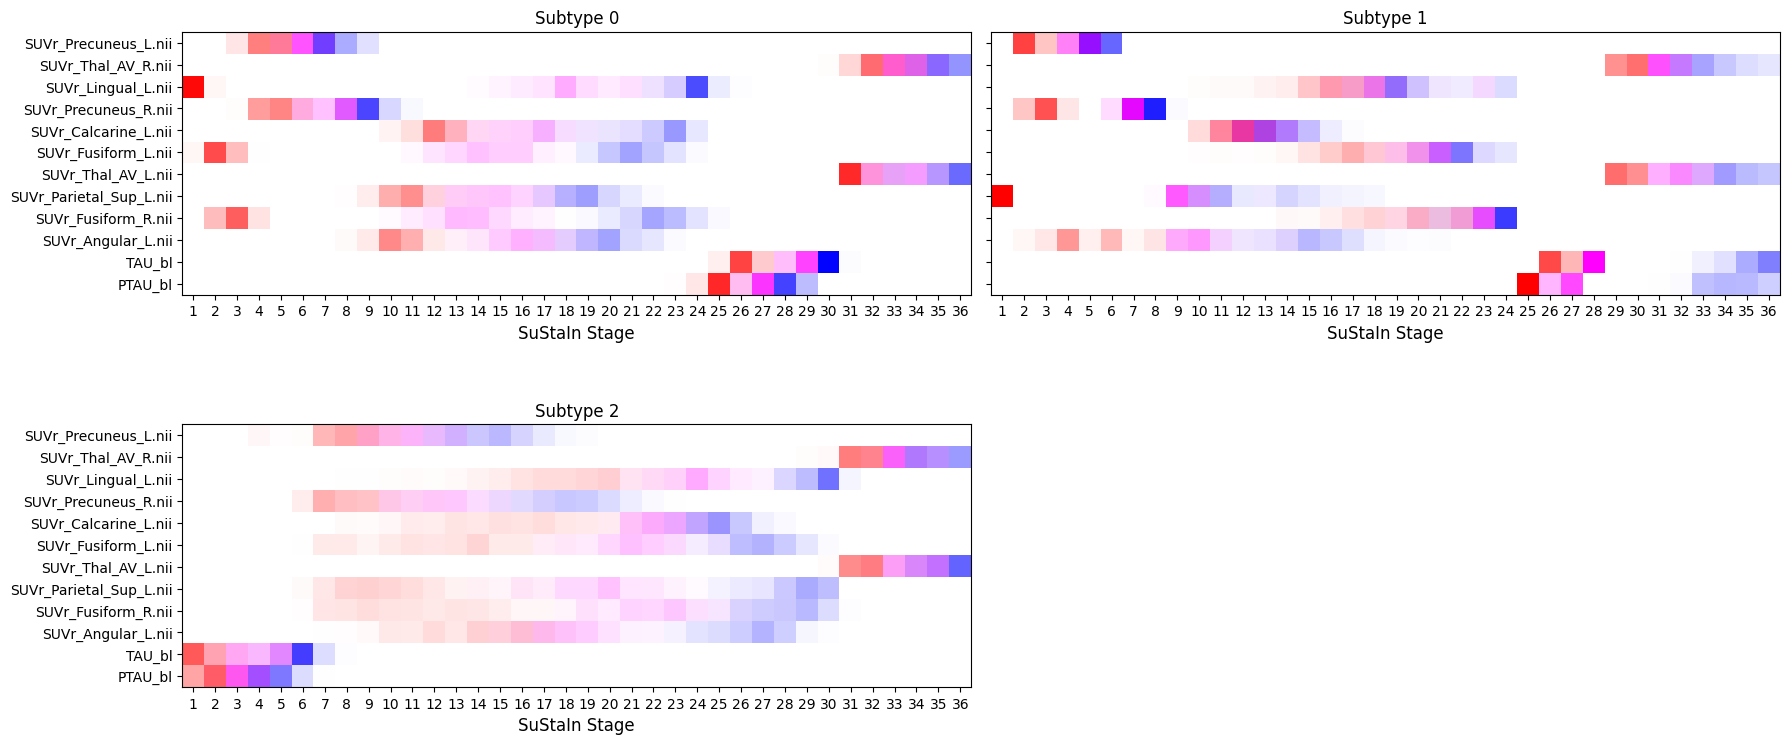

In [329]:
s = 2 # 1 split = 2 subtypes
M = len(biomarkers_df) 

# get the sample sequences and f
pickle_filename_s = output_folder + '/pickle_files/' + dataset_name + '_subtype' + str(s) + '.pickle'
print("Loading pickle file:", pickle_filename_s)
pk = pd.read_pickle(pickle_filename_s)
samples_sequence = pk["samples_sequence"]
samples_f = pk["samples_f"]

# use this information to plot the positional variance diagrams
tmp=ZscoreSustain._plot_sustain_model(sustain_input,samples_sequence,samples_f,M, figsize = (18,8), biomarker_labels=features, subtype_titles=['Subtype 0', 'Subtype 1', 'Subtype 2'])

In [269]:
pk.keys()

dict_keys(['samples_sequence', 'samples_f', 'samples_likelihood', 'ml_subtype', 'prob_ml_subtype', 'ml_stage', 'prob_ml_stage', 'prob_subtype', 'prob_stage', 'prob_subtype_stage', 'ml_sequence_EM', 'ml_sequence_prev_EM', 'ml_f_EM', 'ml_f_prev_EM'])

In [294]:
zdata = biomarkers_df.copy()

s = 2
pickle_filename_s = output_folder + '/pickle_files/' + dataset_name + '_subtype' + str(s) + '.pickle'
print("Loading pickle file:", pickle_filename_s)
pk = pd.read_pickle(pickle_filename_s)

for variable in ['ml_subtype', # the assigned subtype
                 'prob_ml_subtype', # the probability of the assigned subtype
                 'ml_stage', # the assigned stage 
                 'prob_ml_stage',]: # the probability of the assigned stage
    
    # add SuStaIn output to dataframe
    zdata.loc[:,variable] = pk[variable] 

# let's also add the probability for each subject of being each subtype
for i in range(s):
    zdata.loc[:,'prob_S%s'%i] = pk['prob_subtype'][:,i]
zdata.head()

Loading pickle file: c:\Users\huw\OneDrive\Documents\Research_Internship\adni-ml\12feats_csf/pickle_files/12feats_csf_subtype2.pickle


,PTID,TAU_bl,PTAU_bl,ABETA_bl,EXAMDATE,EXAMDATE_bl,DX_bl,DX,AGE,PTGENDER,...,SUVr_Vermis_9.nii,SUVr_Vermis_10.nii,SUVr_VTA_L.nii,SUVr_VTA_R.nii,ml_subtype,prob_ml_subtype,ml_stage,prob_ml_stage,prob_S0,prob_S1
1,100_S_5280,-2.233807,-1.955737,731.8,2015-09-29,2013-09-17,2,2,67.5,0,...,0.259658,-0.306130,-1.147140,-1.018268,0.0,0.519822,0.0,0.380985,0.519822,0.425475
2,027_S_5277,0.765378,1.577642,780.3,2015-08-31,2013-08-28,2,2,71.8,1,...,-0.772522,-0.603690,-0.466361,-0.509310,1.0,0.794920,27.0,0.177906,0.205080,0.794920
3,135_S_5275,2.986599,4.308707,832.7,2014-02-25,2013-08-27,0,0,78.0,1,...,-1.058055,-1.043347,-0.071741,0.279041,0.0,0.902705,30.0,0.339371,0.902705,0.070157
4,135_S_5269,-2.139915,-1.887424,590.4,2015-09-01,2013-08-20,2,2,64.9,0,...,1.365481,0.256133,-0.724118,-0.812586,0.0,0.618061,0.0,0.140751,0.618061,0.373085
5,007_S_5265,-0.276825,0.180860,466.1,2015-08-25,2013-08-12,2,2,75.1,1,...,-0.164410,-1.866826,-1.578615,-0.821609,0.0,0.554092,4.0,0.083731,0.554092,0.430943


In [295]:
zdata[zdata['ml_subtype'] == 0.0]

,PTID,TAU_bl,PTAU_bl,ABETA_bl,EXAMDATE,EXAMDATE_bl,DX_bl,DX,AGE,PTGENDER,...,SUVr_Vermis_9.nii,SUVr_Vermis_10.nii,SUVr_VTA_L.nii,SUVr_VTA_R.nii,ml_subtype,prob_ml_subtype,ml_stage,prob_ml_stage,prob_S0,prob_S1
1,100_S_5280,-2.233807,-1.955737,731.8,2015-09-29,2013-09-17,2,2,67.5,0,...,0.259658,-0.306130,-1.147140,-1.018268,0.0,0.519822,0.0,0.380985,0.519822,0.425475
3,135_S_5275,2.986599,4.308707,832.7,2014-02-25,2013-08-27,0,0,78.0,1,...,-1.058055,-1.043347,-0.071741,0.279041,0.0,0.902705,30.0,0.339371,0.902705,0.070157
4,135_S_5269,-2.139915,-1.887424,590.4,2015-09-01,2013-08-20,2,2,64.9,0,...,1.365481,0.256133,-0.724118,-0.812586,0.0,0.618061,0.0,0.140751,0.618061,0.373085
5,007_S_5265,-0.276825,0.180860,466.1,2015-08-25,2013-08-12,2,2,75.1,1,...,-0.164410,-1.866826,-1.578615,-0.821609,0.0,0.554092,4.0,0.083731,0.554092,0.430943
6,032_S_5263,2.519820,4.177895,684.4,2016-01-05,2013-10-07,2,2,75.2,1,...,0.967609,0.966878,-0.210845,-0.909640,0.0,0.901862,32.0,0.361589,0.901862,0.097906
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
529,012_S_5121,-1.392801,-1.493535,1700.0,2015-04-30,2013-04-30,3,0,76.8,0,...,-0.895845,-0.134368,0.610510,0.800475,0.0,0.560795,0.0,0.390814,0.560795,0.330629
531,041_S_5141,-0.722143,-0.721744,1700.0,2015-07-02,2013-04-30,3,2,76.7,0,...,-0.114895,-0.287621,0.559916,0.484503,0.0,0.792381,2.0,0.172377,0.792381,0.197304
532,006_S_5153,-0.345233,-0.415062,1700.0,2015-08-05,2013-05-20,3,2,79.0,0,...,-1.409791,-1.666934,0.040678,-0.518500,0.0,0.556588,0.0,0.311467,0.556588,0.328276
542,127_S_5266,0.163126,0.108186,1700.0,2015-08-06,2013-08-15,3,2,65.9,0,...,1.225569,1.640913,0.089042,0.328973,0.0,0.938403,2.0,0.213208,0.938403,0.040201


In [296]:
zdata.ml_subtype.value_counts()



ml_subtype
0.0    275
1.0    201
2.0     67
Name: count, dtype: int64

In [297]:
zdata.loc[:,'ml_subtype'] = zdata.ml_subtype.values

# convert "Stage 0" subjects to subtype 0
# zdata.loc[zdata.ml_stage==0,'ml_subtype'] = 3.0

In [298]:
zdata.ml_subtype.value_counts()


ml_subtype
0.0    275
1.0    201
2.0     67
Name: count, dtype: int64

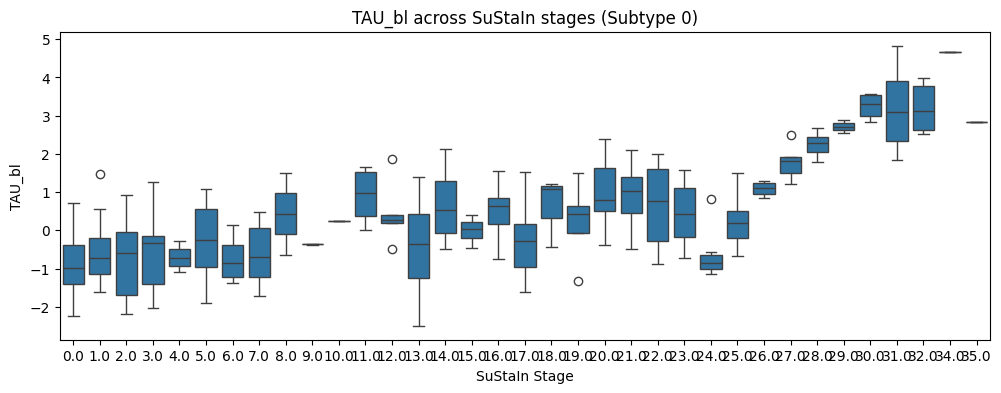

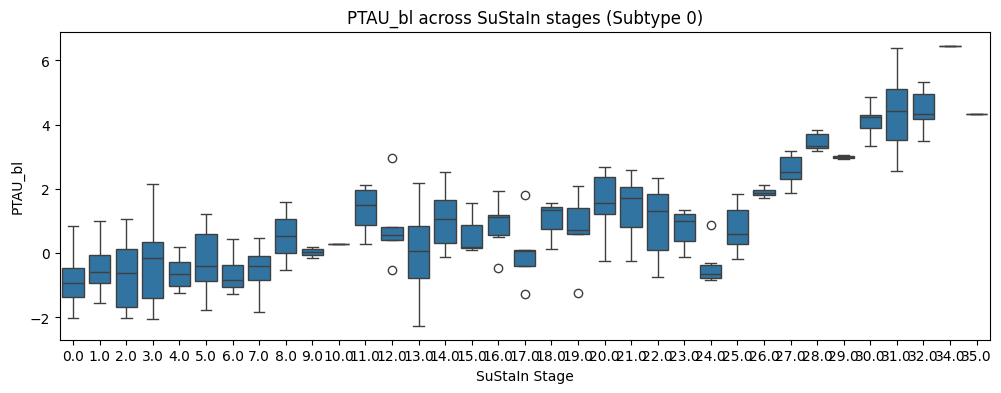

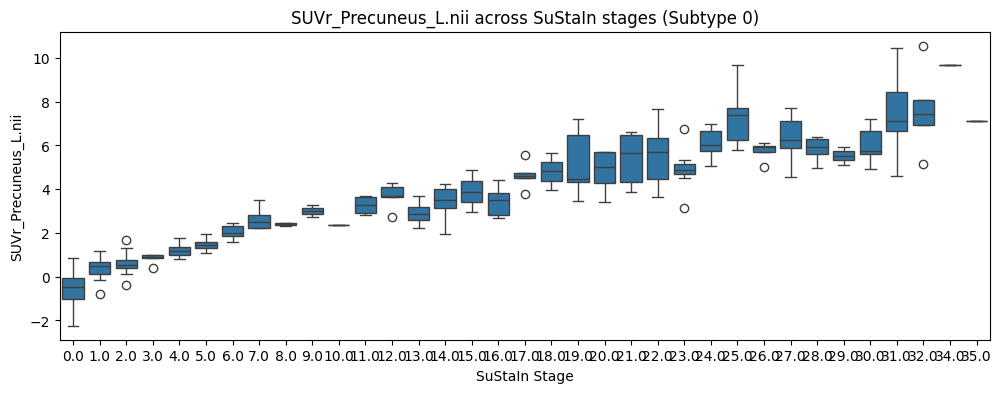

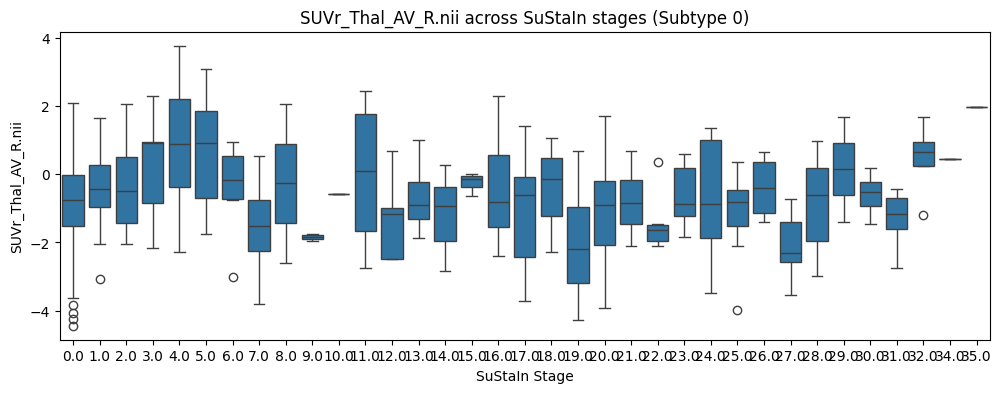

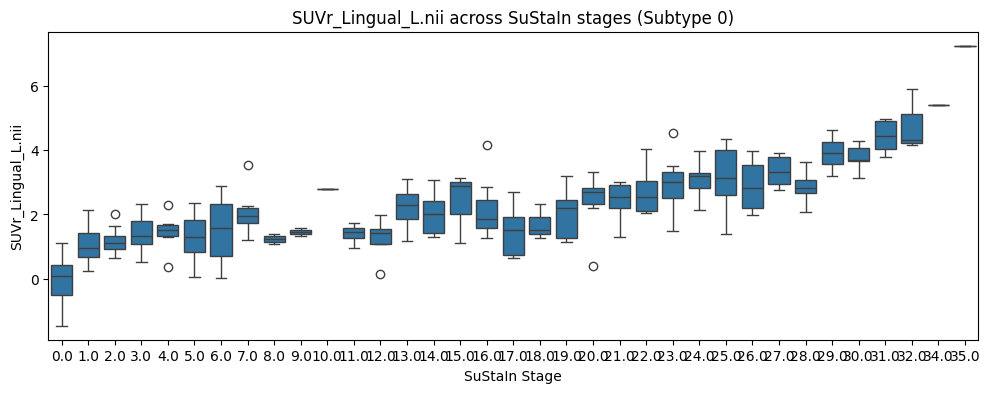

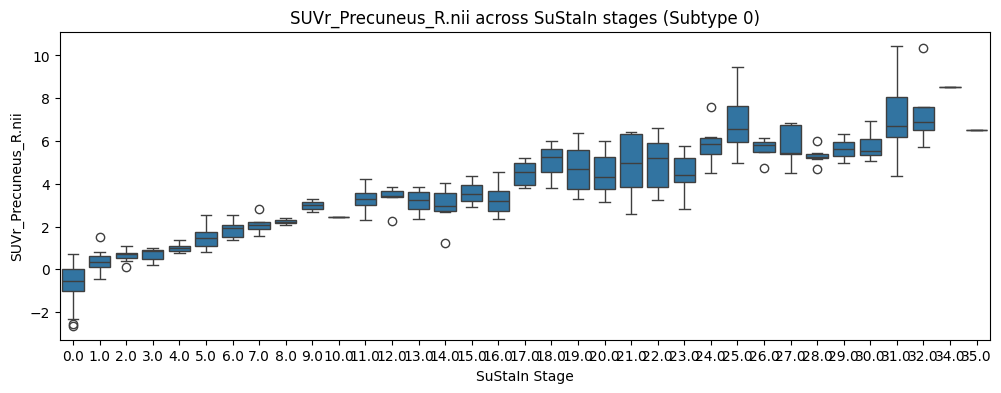

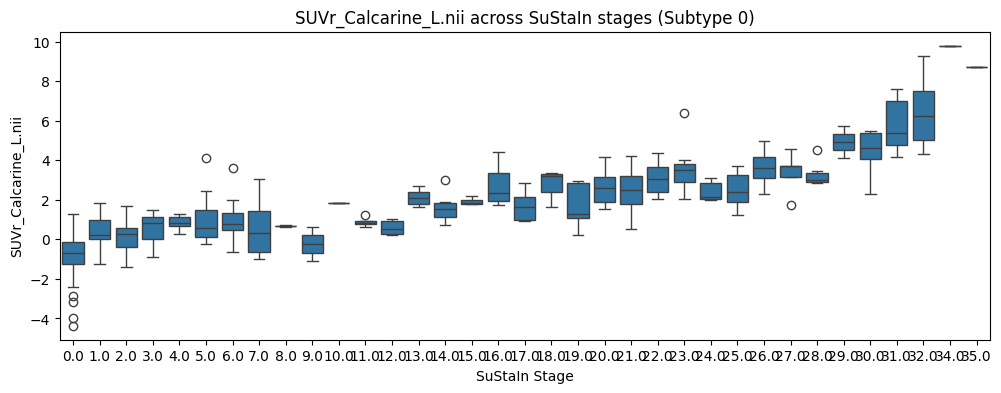

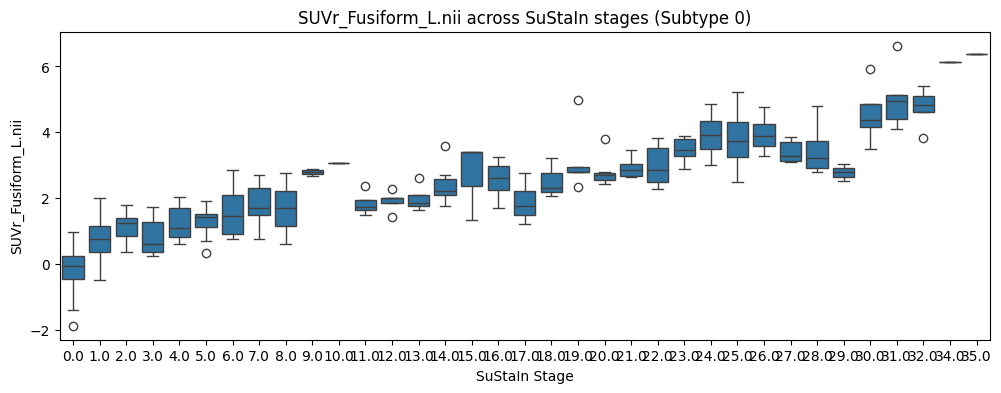

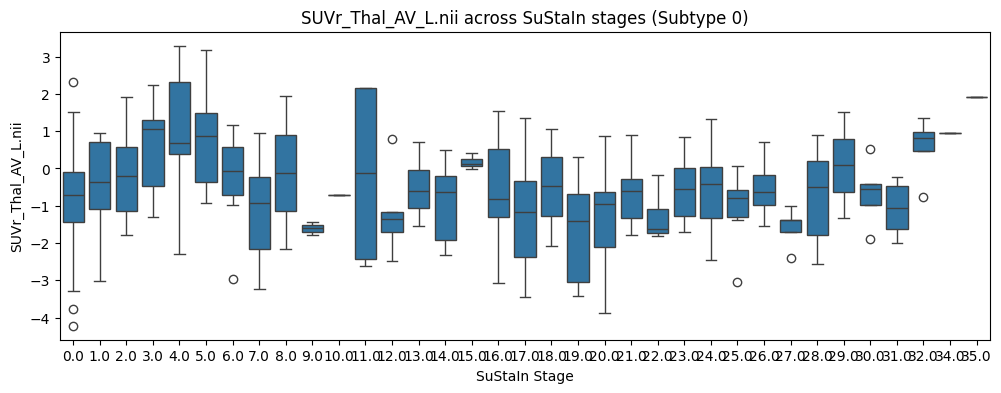

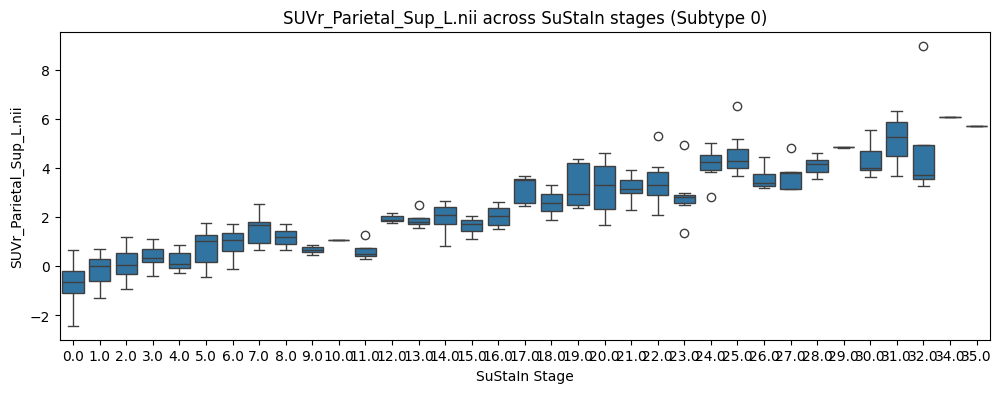

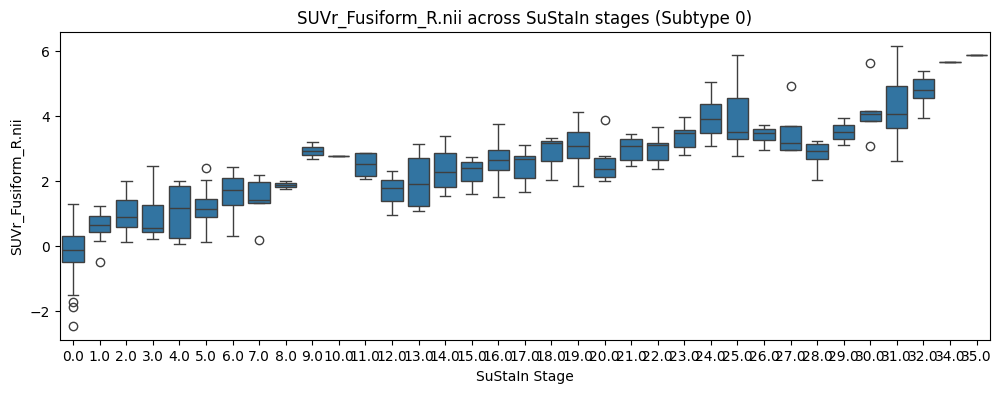

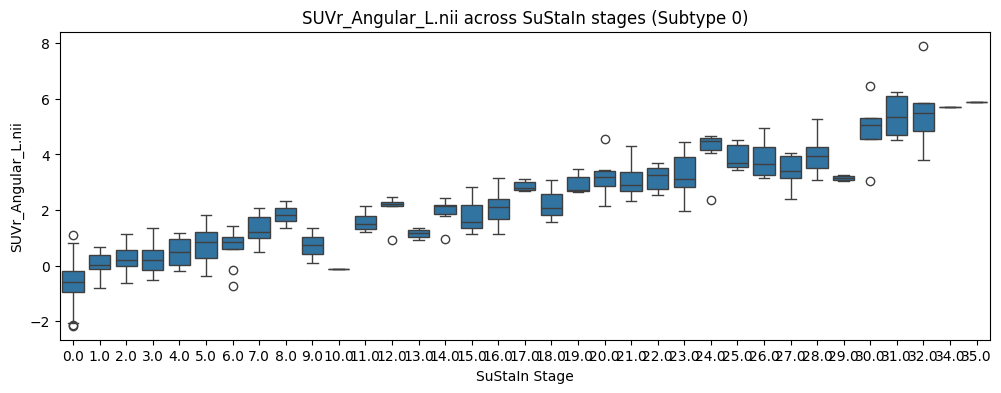

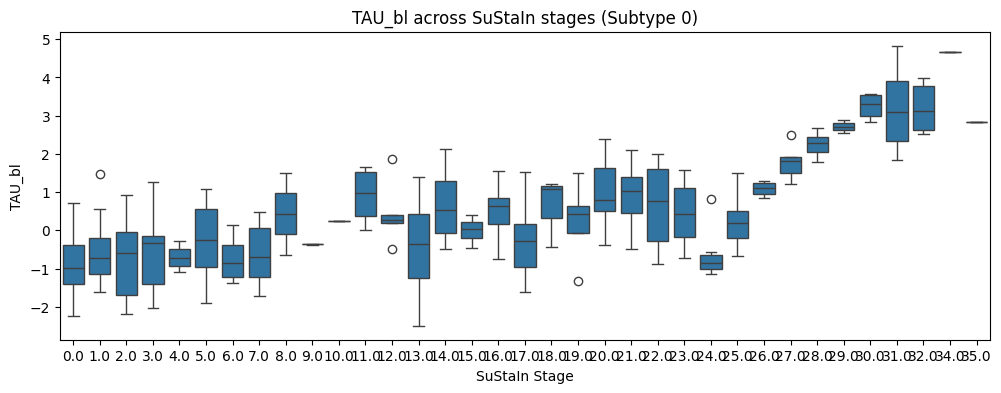

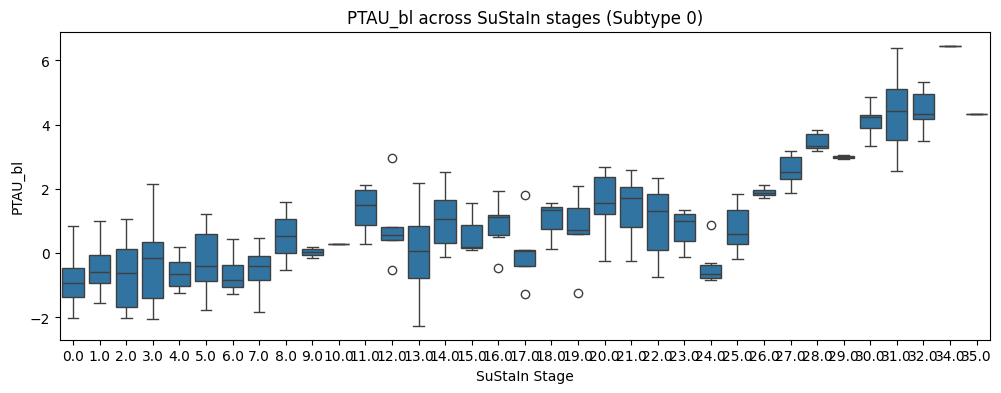

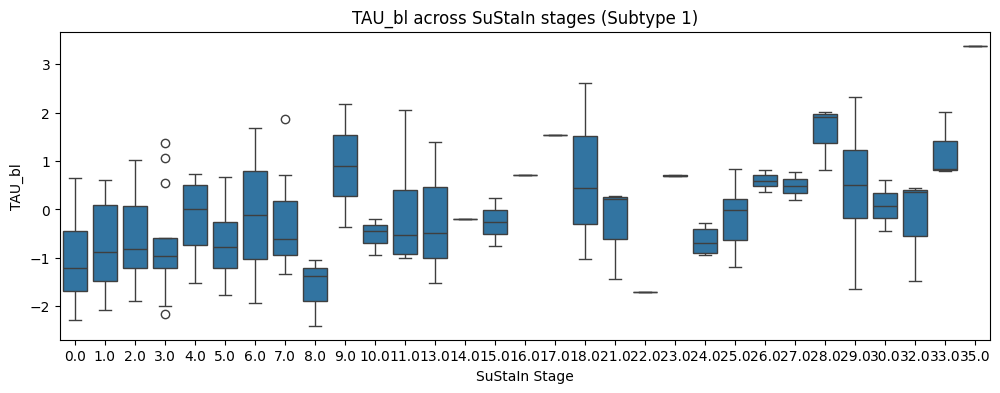

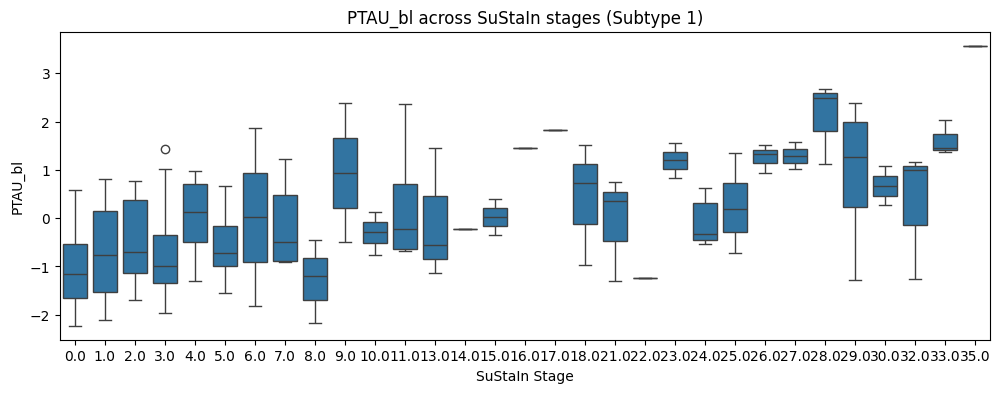

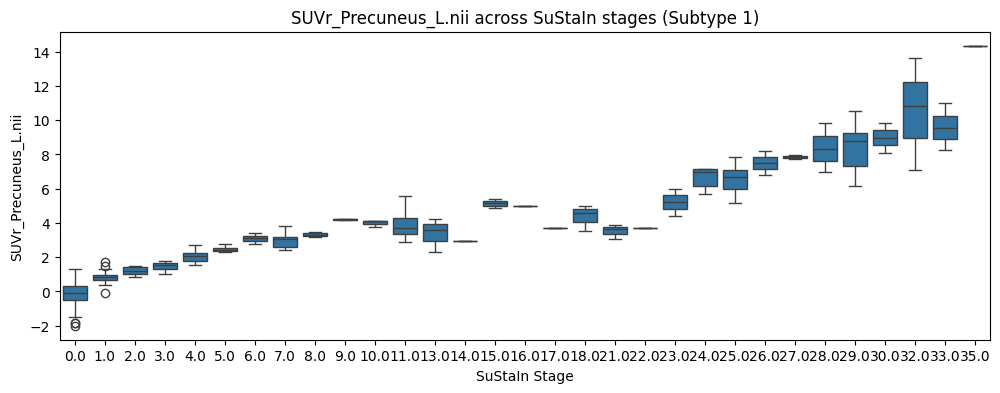

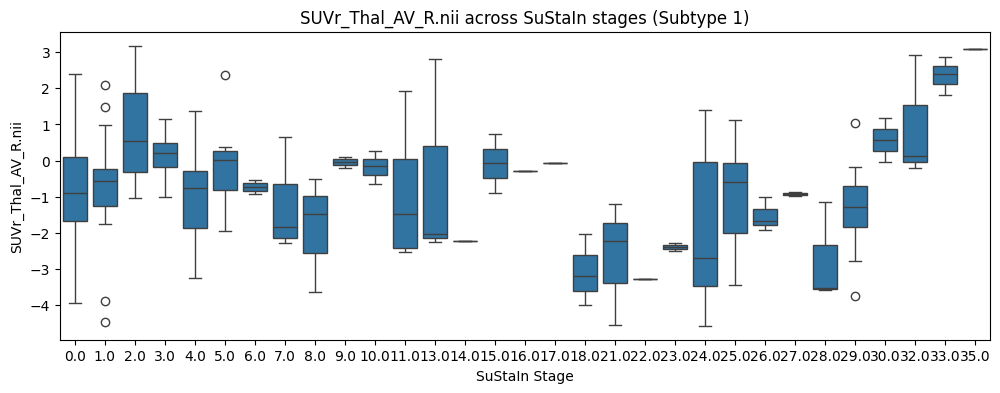

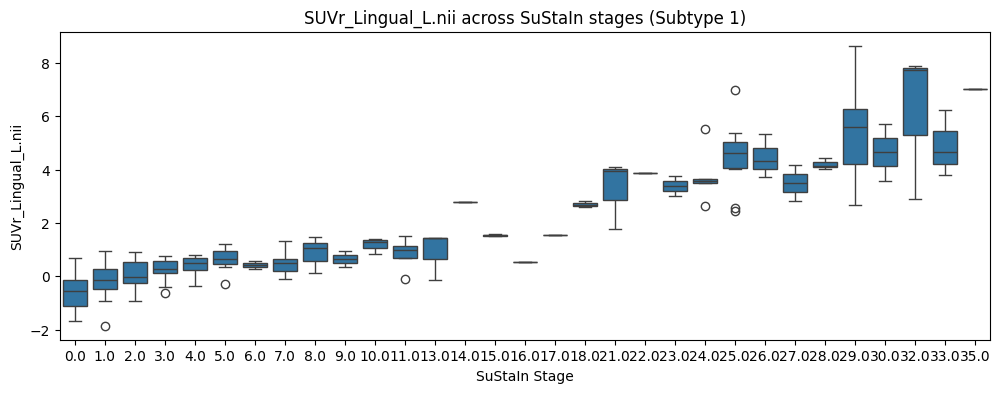

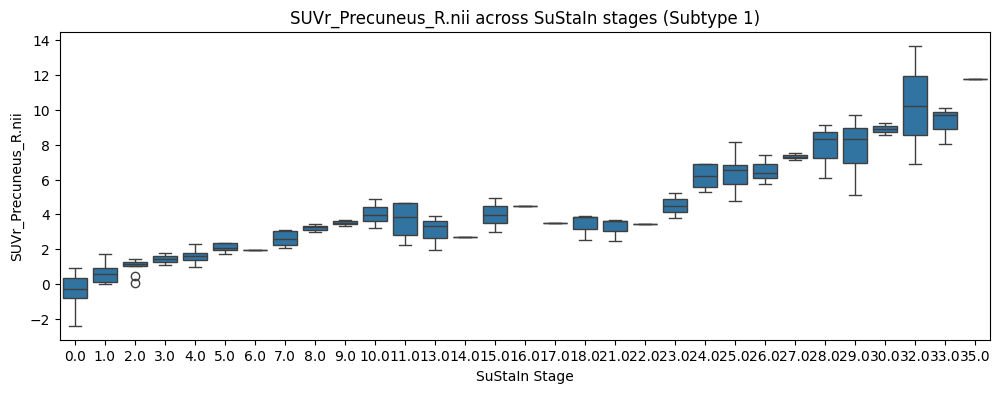

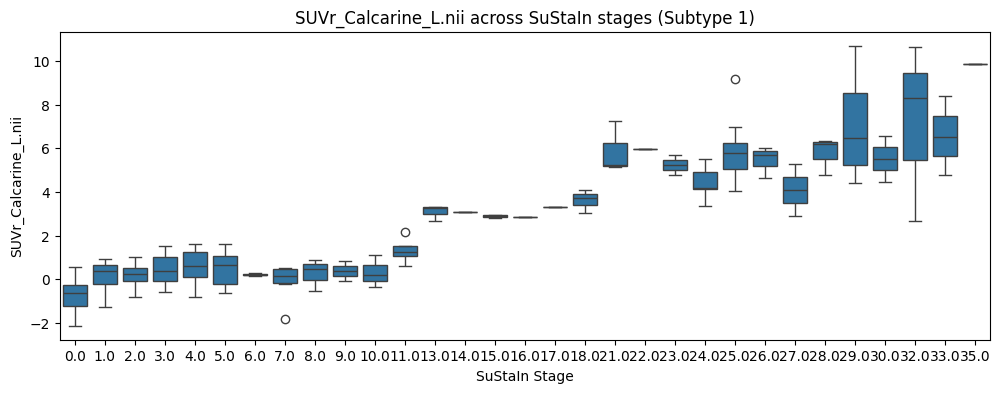

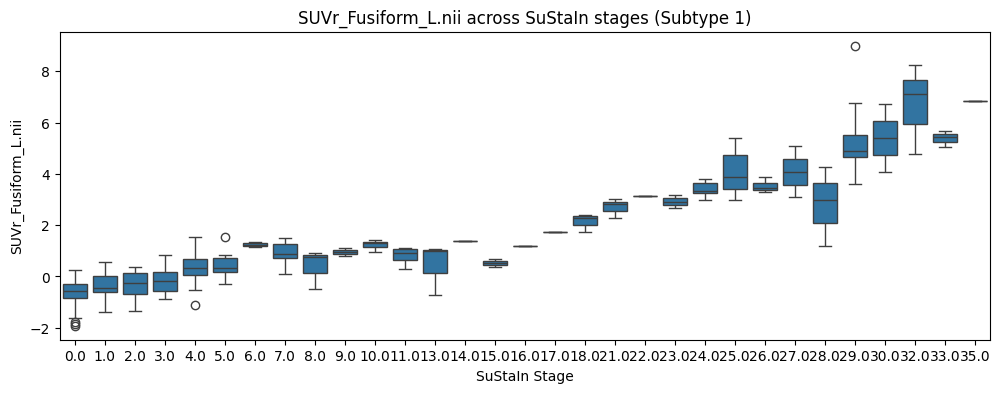

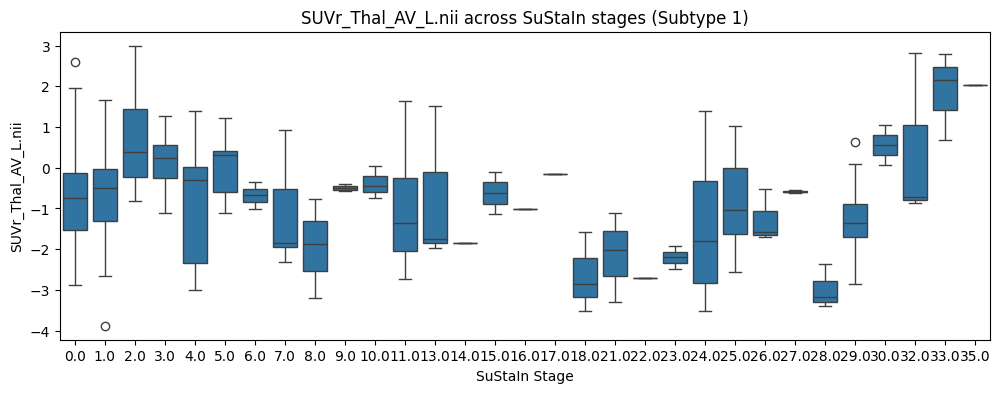

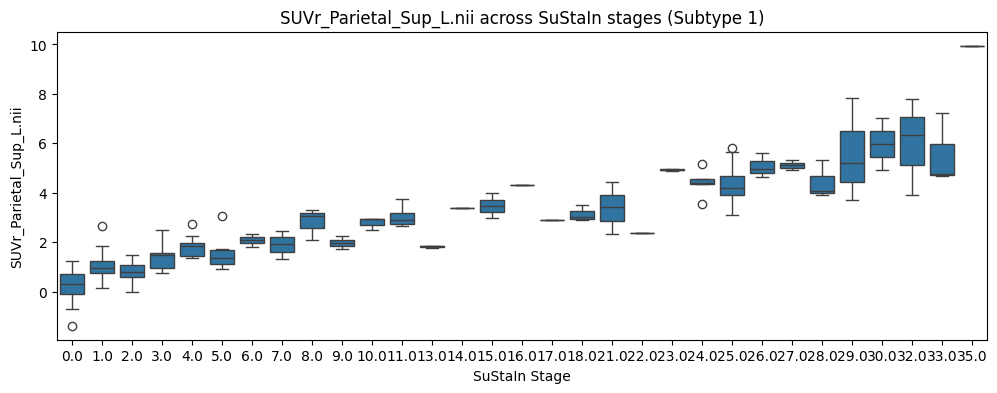

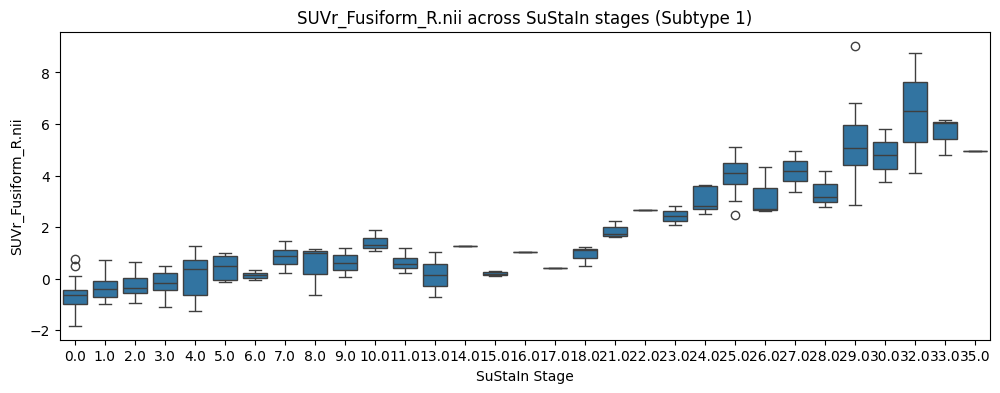

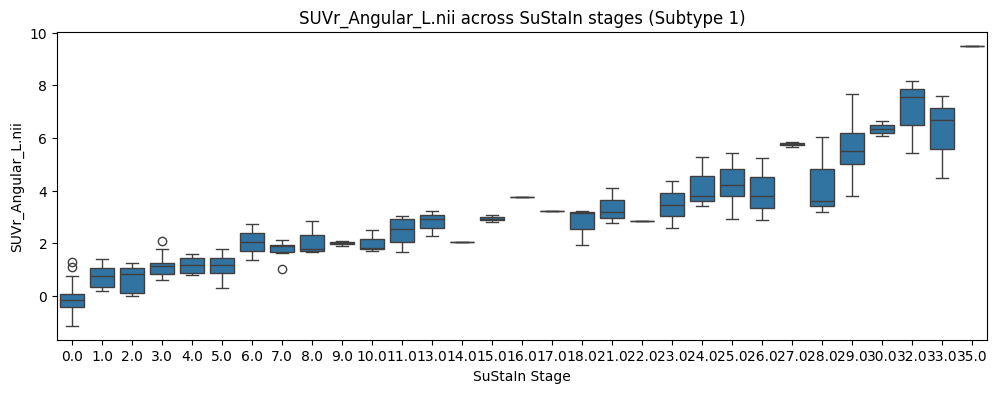

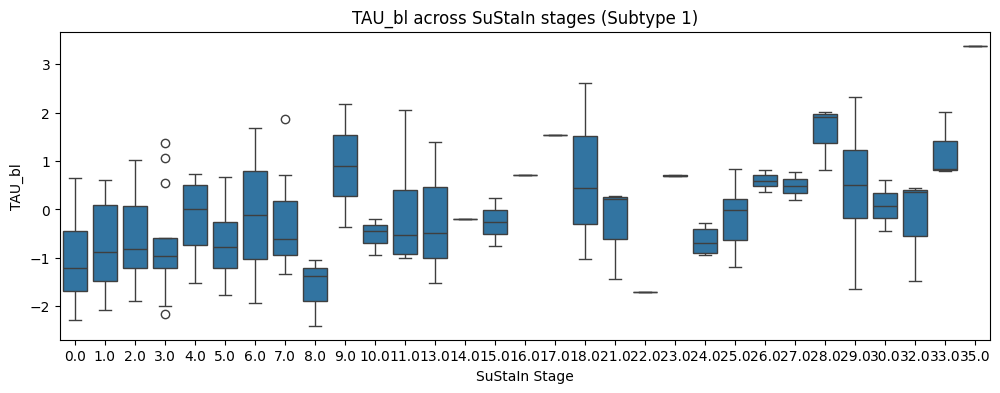

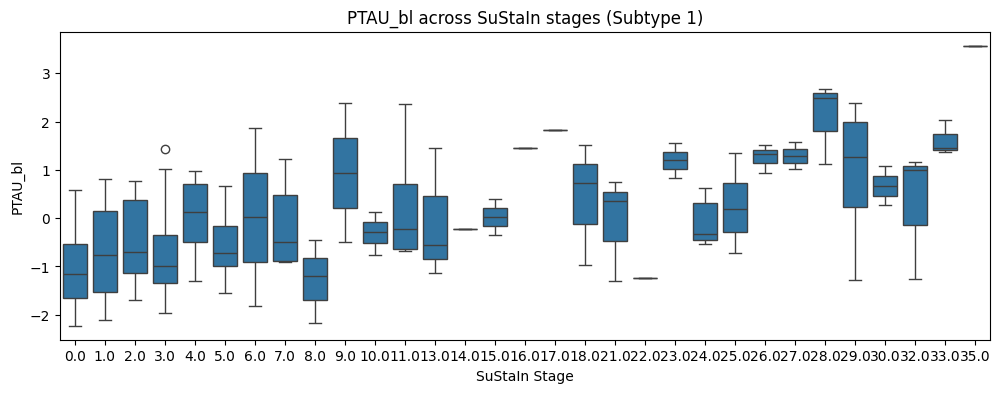

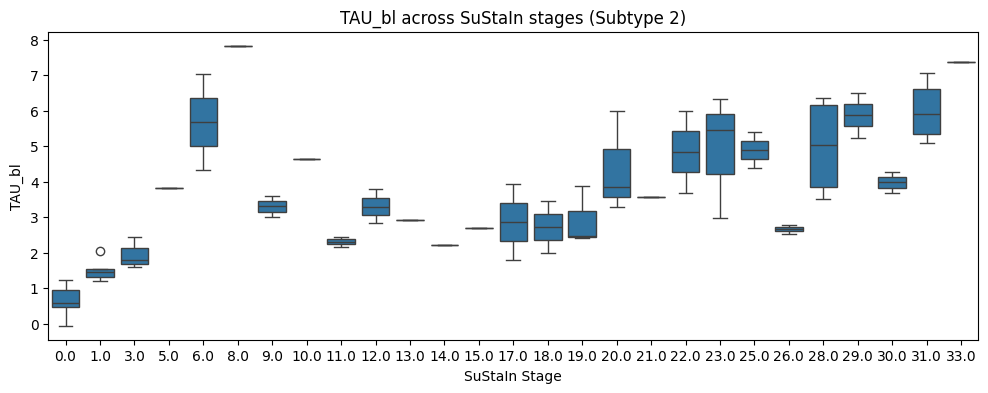

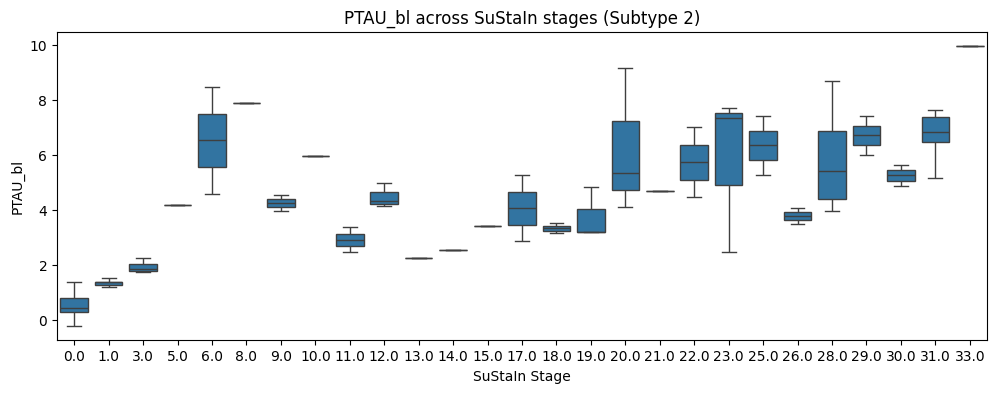

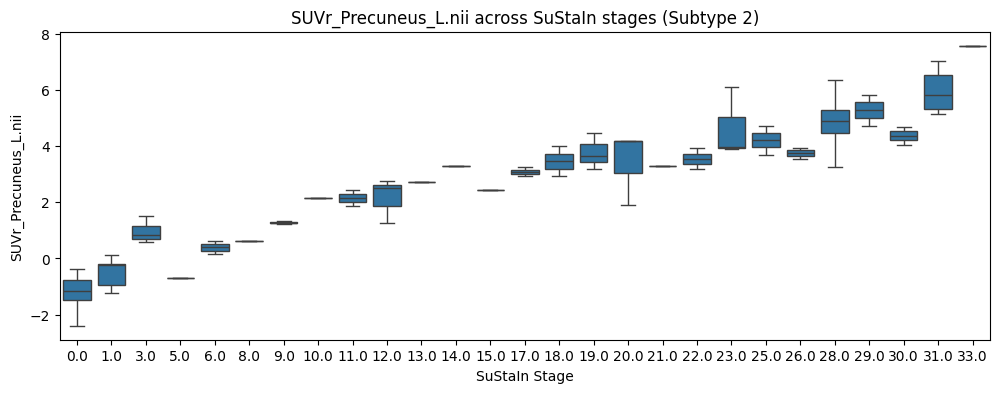

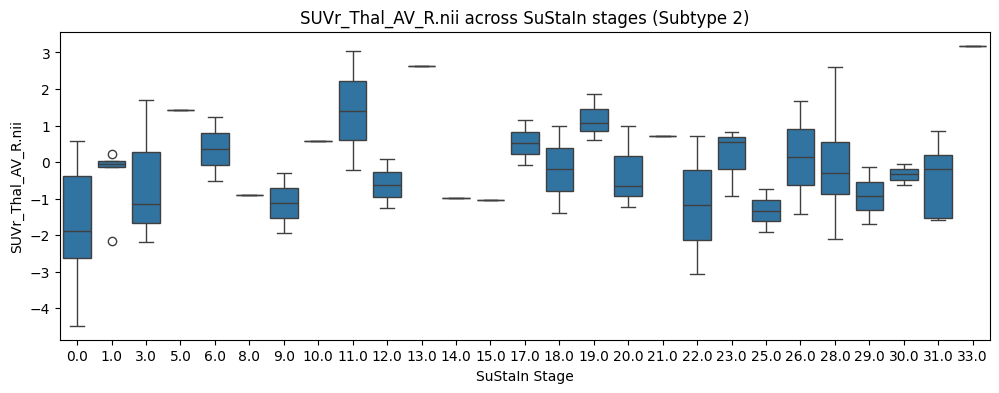

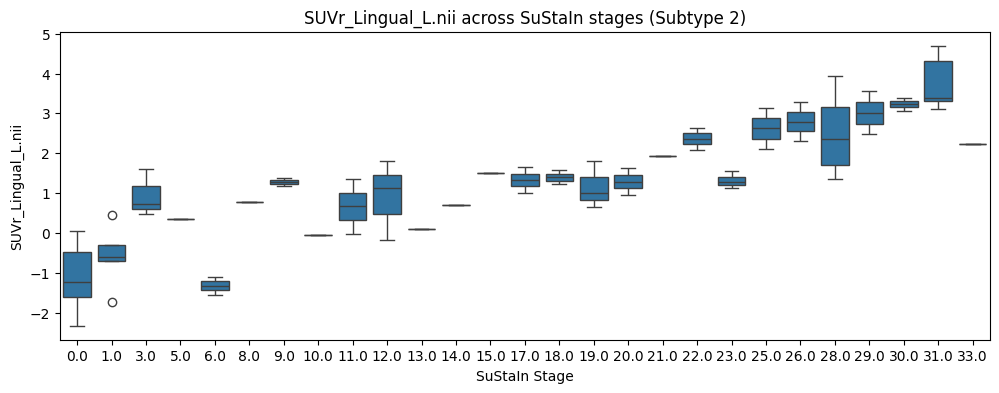

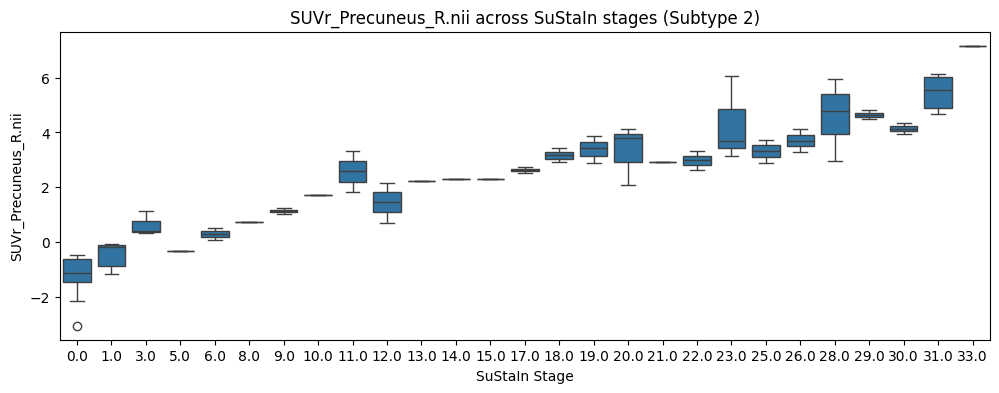

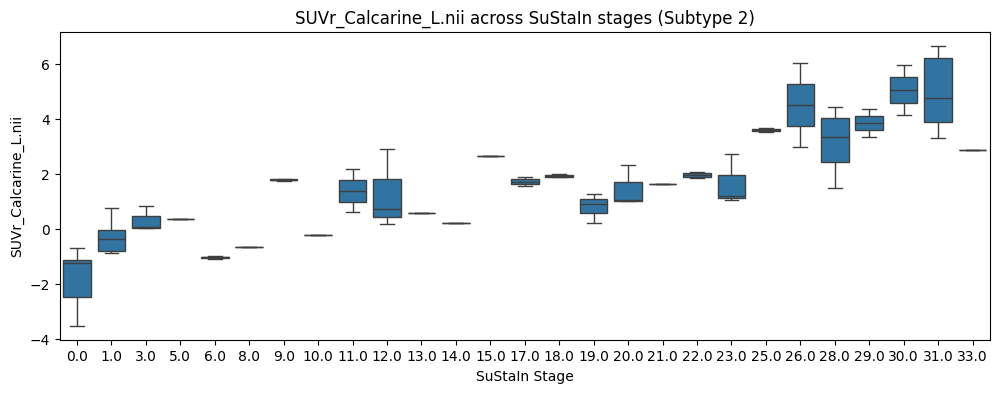

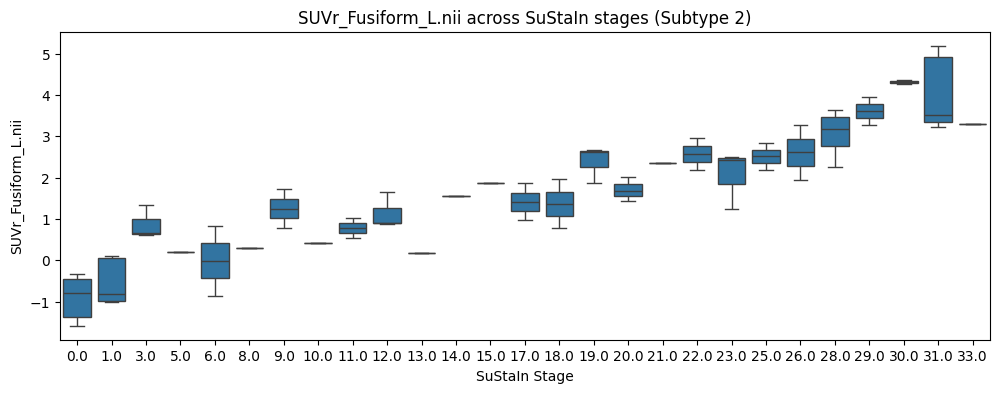

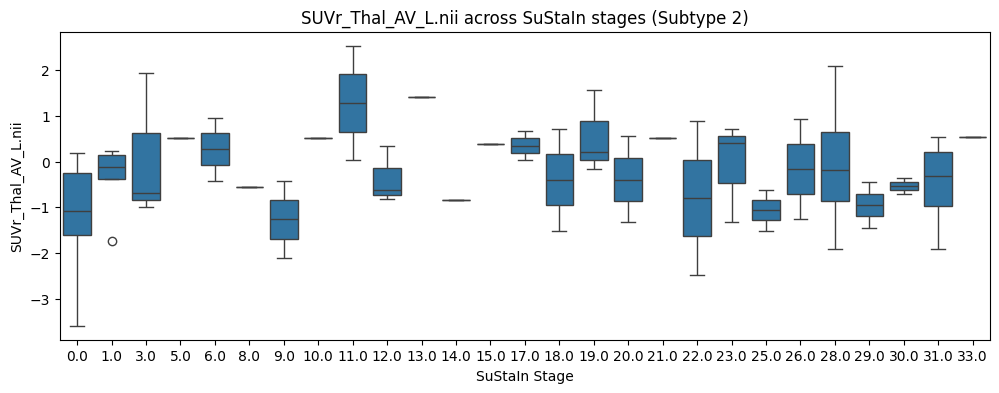

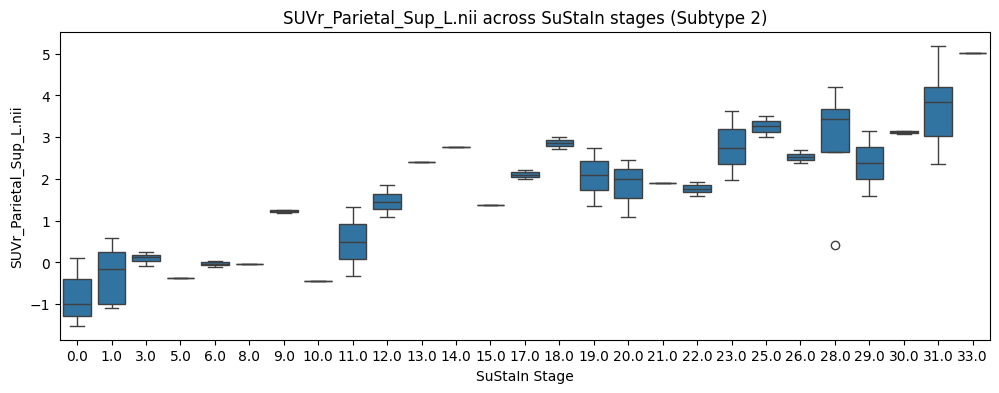

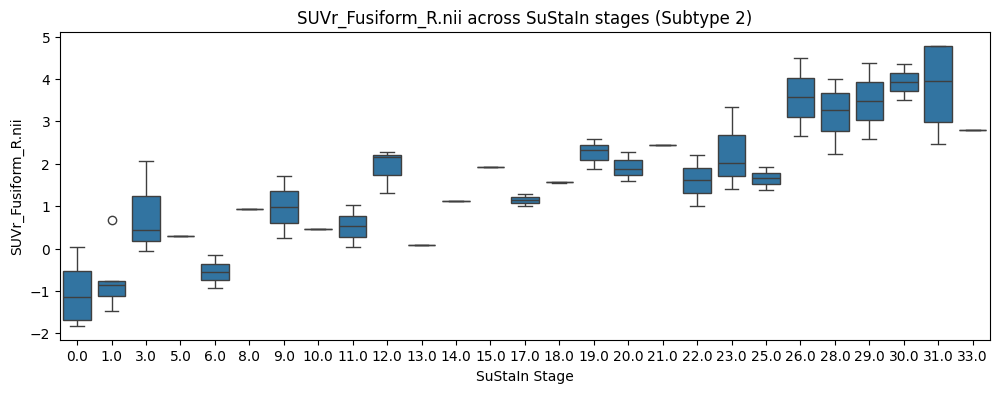

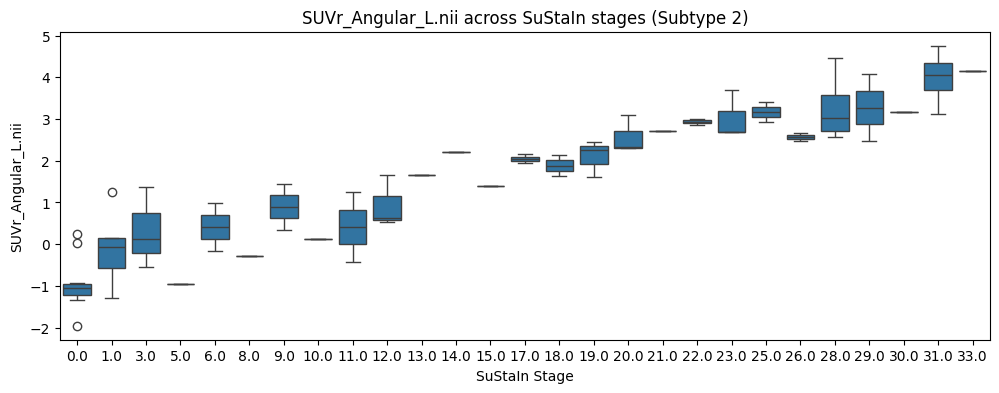

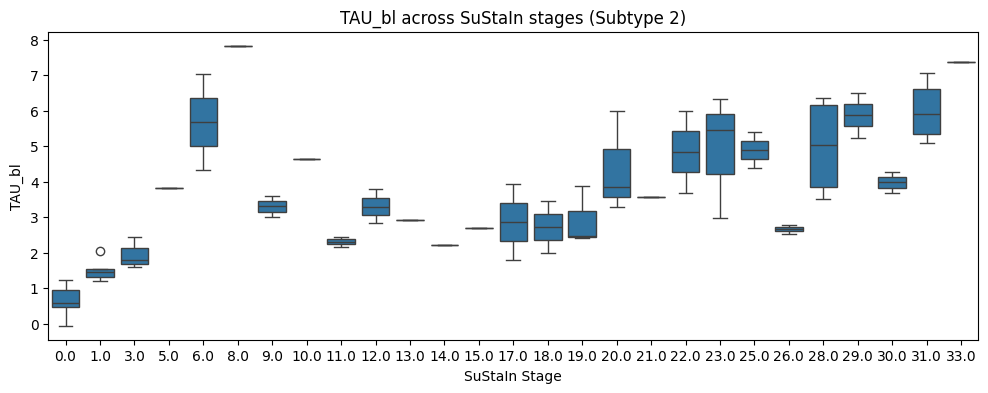

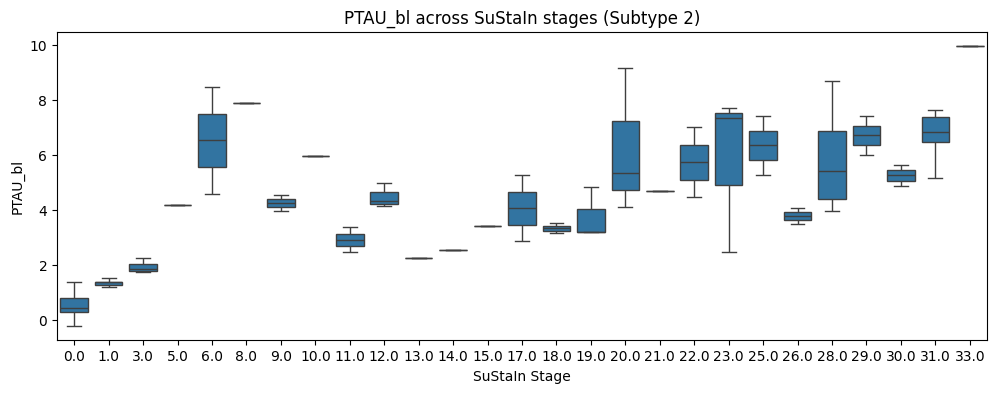

In [308]:
# find subjects who are subtype 0 and stage < 5

high_tau = zdata[(zdata['ml_subtype'] == 0.0) & (zdata['ml_stage'] < 6)]

features_to_view = [
 'TAU_bl',
 'PTAU_bl'] + features


for i in range(0,3):
    sub = zdata[zdata['ml_subtype'] == i]
    for feat in features_to_view:
        plt.figure(figsize=(12, 4))
        sns.boxplot(data=sub, x='ml_stage', y=feat)
        plt.title(f"{feat} across SuStaIn stages (Subtype {i})")
        plt.xlabel("SuStaIn Stage")
        plt.ylabel(feat)
        plt.show()

IndexError: index 6 is out of bounds for axis 0 with size 6

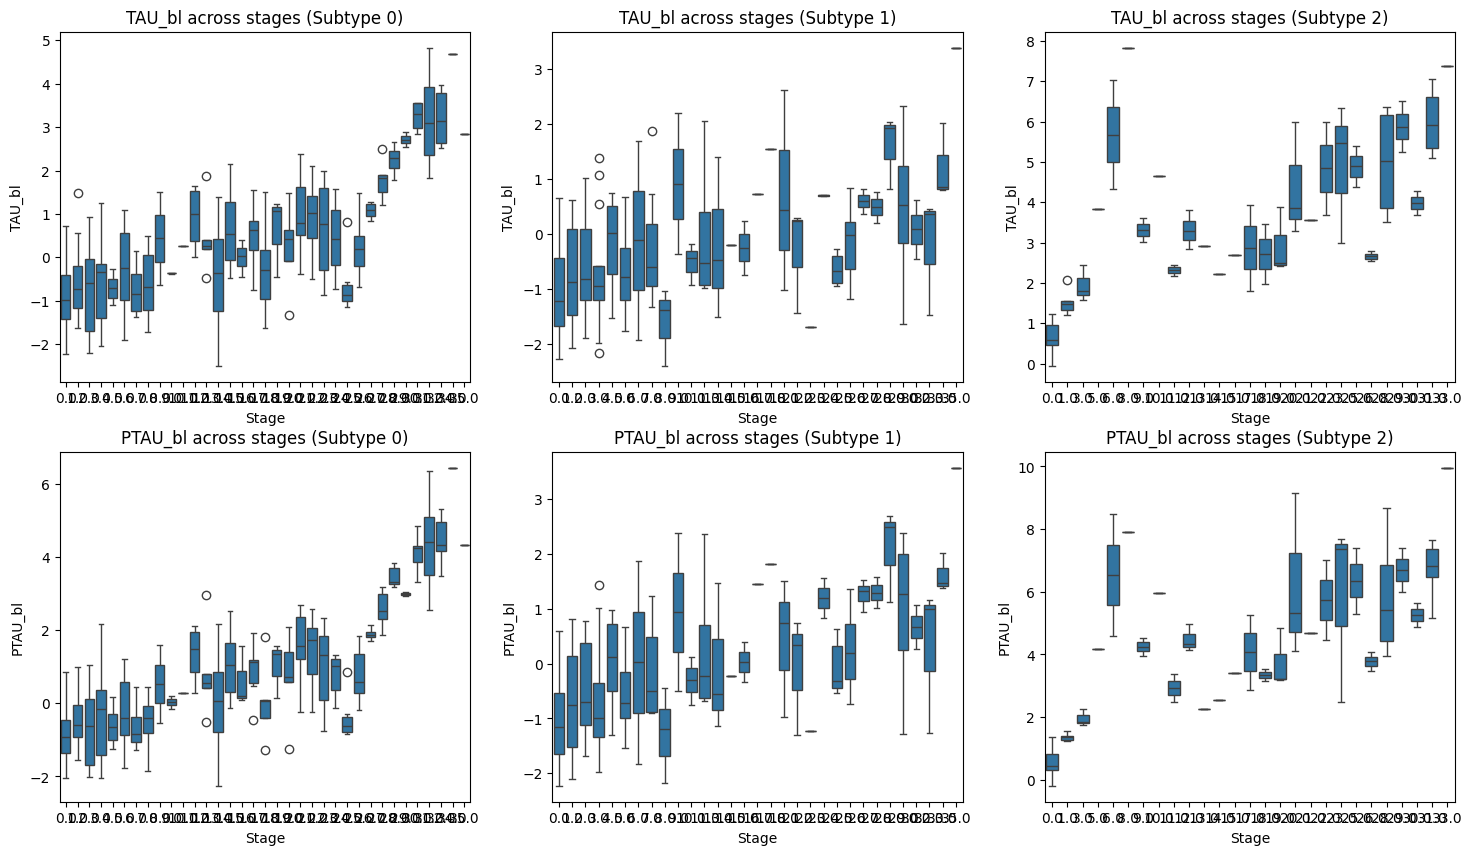

In [ ]:
subtypes = [0, 1, 2]

# Create 2 rows × 3 columns = 6 plots
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
axs = axs.flatten()

plot_idx = 0
for feat in features_to_view:
    for subtype in subtypes:
        sub = zdata[zdata['ml_subtype'] == subtype]
        sns.boxplot(data=sub, x='ml_stage', y=feat, ax=axs[plot_idx])
        axs[plot_idx].set_title(f"{feat} across stages (Subtype {subtype})")
        axs[plot_idx].set_xlabel("Stage")
        axs[plot_idx].set_ylabel(feat)
        plot_idx += 1

plt.tight_layout()
plt.show()

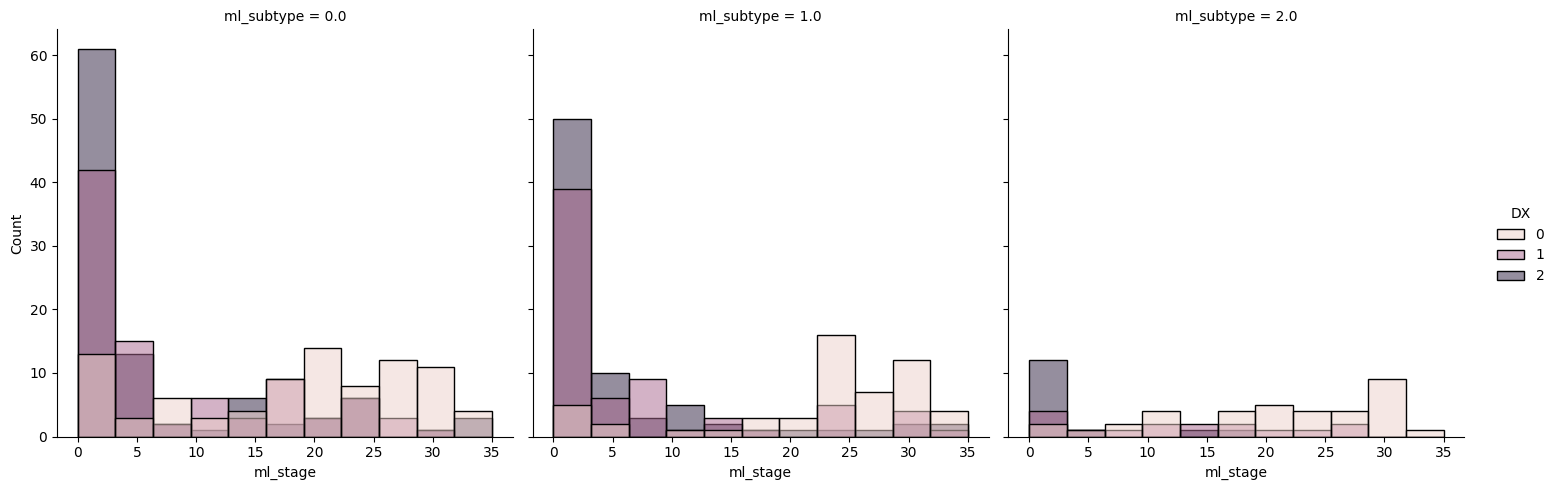

In [ ]:
sns.hisplot(x='ml_stage',hue='DX',data=zdata,col='ml_subtype')


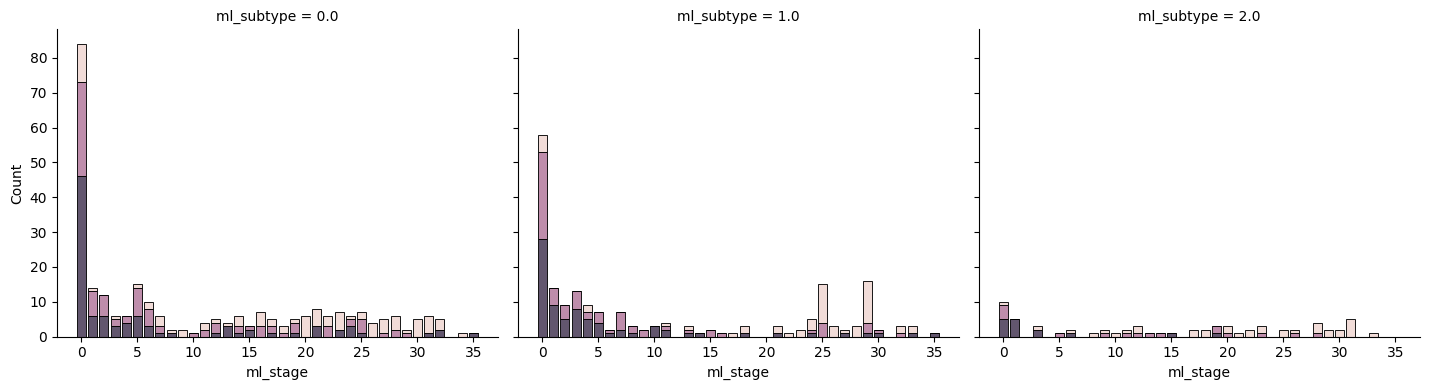

In [320]:
from matplotlib.pyplot import legend


g = sns.FacetGrid(zdata, col="ml_subtype", height=4, aspect=1.2)
g.map_dataframe(sns.histplot, x="ml_stage", hue="DX", multiple="stack", discrete=True, shrink=0.8, legend=True)
g.add_legend()
plt.show()

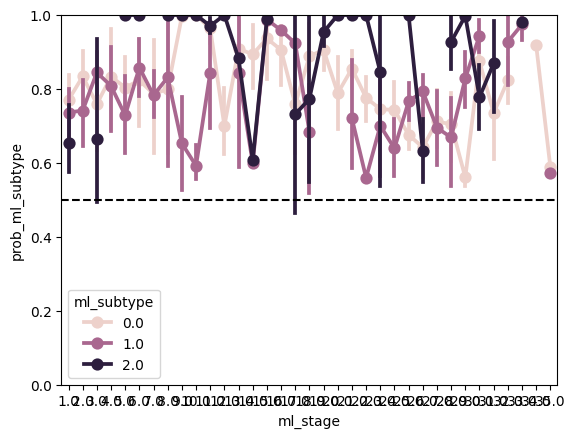

In [217]:
sns.pointplot(x='ml_stage',y='prob_ml_subtype', # input variables
              hue='ml_subtype',                 # "grouping" variable
            data=zdata[zdata.ml_subtype<3]) # only plot for Subtypes 1 and 2 (not 0)
plt.ylim(0,1) 
plt.axhline(0.5,ls='--',color='k') # plot a line representing change (0.5 in the case of 2 subtypes)

In [218]:
zdata['ml_subtype'].value_counts()

ml_subtype
0.0    191
3.0    152
1.0    143
2.0     57
Name: count, dtype: int64

In [219]:
zdata

,PTID,TAU_bl,PTAU_bl,ABETA_bl,EXAMDATE,EXAMDATE_bl,DX_bl,DX,AGE,PTGENDER,...,SUVr_Vermis_9.nii,SUVr_Vermis_10.nii,SUVr_VTA_L.nii,SUVr_VTA_R.nii,ml_subtype,prob_ml_subtype,ml_stage,prob_ml_stage,prob_S0,prob_S1
1,100_S_5280,-2.233807,-1.955737,731.8,2015-09-29,2013-09-17,2,2,67.5,0,...,0.259658,-0.306130,-1.147140,-1.018268,3.0,0.519822,0.0,0.380985,0.519822,0.425475
2,027_S_5277,0.765378,1.577642,780.3,2015-08-31,2013-08-28,2,2,71.8,1,...,-0.772522,-0.603690,-0.466361,-0.509310,1.0,0.794920,27.0,0.177906,0.205080,0.794920
3,135_S_5275,2.986599,4.308707,832.7,2014-02-25,2013-08-27,0,0,78.0,1,...,-1.058055,-1.043347,-0.071741,0.279041,0.0,0.902705,30.0,0.339371,0.902705,0.070157
4,135_S_5269,-2.139915,-1.887424,590.4,2015-09-01,2013-08-20,2,2,64.9,0,...,1.365481,0.256133,-0.724118,-0.812586,3.0,0.618061,0.0,0.140751,0.618061,0.373085
5,007_S_5265,-0.276825,0.180860,466.1,2015-08-25,2013-08-12,2,2,75.1,1,...,-0.164410,-1.866826,-1.578615,-0.821609,0.0,0.554092,4.0,0.083731,0.554092,0.430943
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
542,127_S_5266,0.163126,0.108186,1700.0,2015-08-06,2013-08-15,3,2,65.9,0,...,1.225569,1.640913,0.089042,0.328973,0.0,0.938403,2.0,0.213208,0.938403,0.040201
543,053_S_5272,0.499797,0.220103,1700.0,2015-09-15,2013-09-04,3,2,69.9,1,...,-0.107575,-0.288091,-1.545589,-2.028012,1.0,0.871204,1.0,0.214112,0.041181,0.871204
544,053_S_5287,0.008875,0.374171,1700.0,2015-09-30,2013-09-18,3,2,78.9,1,...,-0.793930,0.790034,-0.670757,-0.191895,1.0,0.921672,2.0,0.233914,0.041294,0.921672
545,027_S_5288,0.434072,0.443937,1700.0,2015-09-24,2013-09-25,3,2,81.9,1,...,-1.953986,-1.068054,0.049923,0.386135,3.0,0.570341,0.0,0.217105,0.262868,0.570341


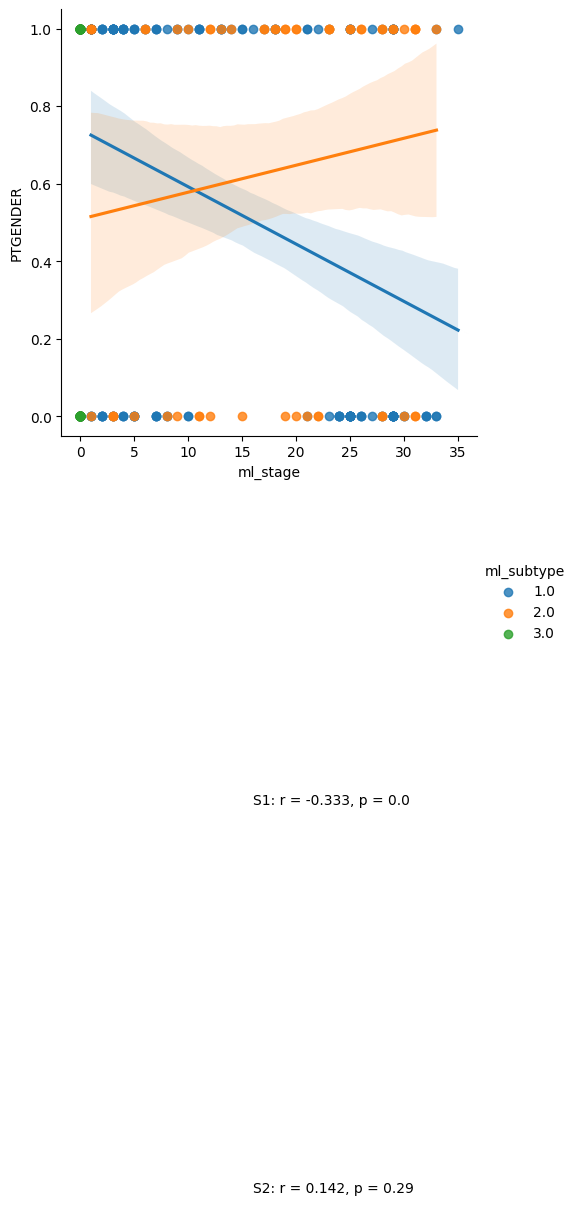

In [220]:
var = 'PTGENDER'

# plot relationship
sns.lmplot(x='ml_stage',y=var,hue='ml_subtype',
          data = zdata[zdata.ml_subtype>0],
           #lowess=True # uncomment if you would prefer a lowess curve to a linear curve
          )

# get stats
for subtype in [1,2]:
    # get r and p value
    r,p = stats.pearsonr(x = zdata.loc[zdata.ml_subtype==subtype,var].values,
                         y = zdata.loc[zdata.ml_subtype==subtype,'ml_stage'].values)
    # add them to plot
    plt.text(16,0-subtype,'S%s: r = %s, p = %s'%(subtype,round(r,3),round(p,2)))

In [321]:
from scipy import stats
results = pd.DataFrame(index=features)
for biomarker in features:
    t,p = stats.ttest_ind(zdata.loc[zdata.ml_subtype==0,biomarker],
                         zdata.loc[zdata.ml_subtype==1,biomarker],)
    results.loc[biomarker,'t'] = t
    results.loc[biomarker,'p'] = p
    
print(results)

                                t         p
SUVr_Precuneus_L.nii    -2.499748  0.012765
SUVr_Thal_AV_R.nii       0.512442  0.608580
SUVr_Lingual_L.nii       0.734617  0.462936
SUVr_Precuneus_R.nii    -2.082786  0.037806
SUVr_Calcarine_L.nii    -2.596212  0.009718
SUVr_Fusiform_L.nii      2.404980  0.016556
SUVr_Thal_AV_L.nii       1.131869  0.258262
SUVr_Parietal_Sup_L.nii -4.866218  0.000002
SUVr_Fusiform_R.nii      2.578844  0.010214
SUVr_Angular_L.nii      -3.445272  0.000621
TAU_bl                   3.530763  0.000455
PTAU_bl                  3.775965  0.000180


In [322]:
pd.crosstab(zdata['ml_subtype'], zdata['DX_bl'])

DX_bl,0,1,2,3
ml_subtype,,,,
0.0,57,120,65,33
1.0,39,83,60,19
2.0,22,28,9,8


<Axes: >

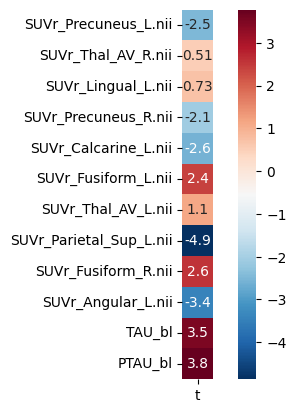

In [323]:
sns.heatmap(pd.DataFrame(results['t']),square=True,annot=True,
           cmap='RdBu_r')

<Axes: xlabel='ml_subtype', ylabel='PTGENDER'>

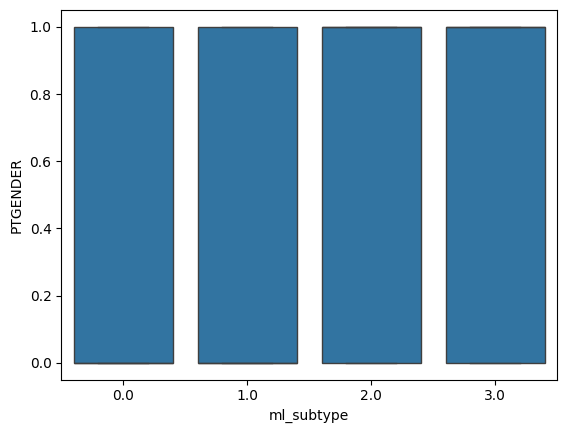

In [121]:
sns.boxplot(x='ml_subtype',y=var,data=zdata)

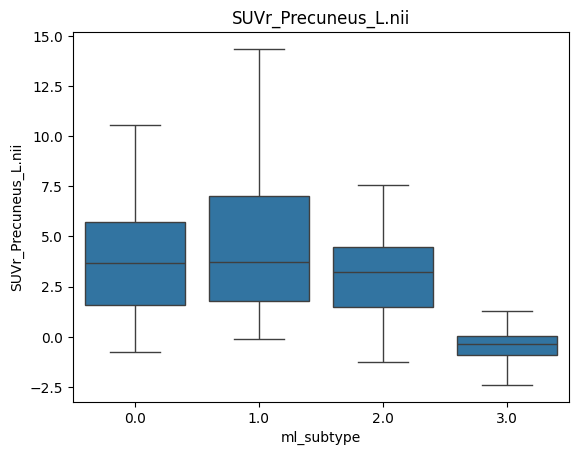

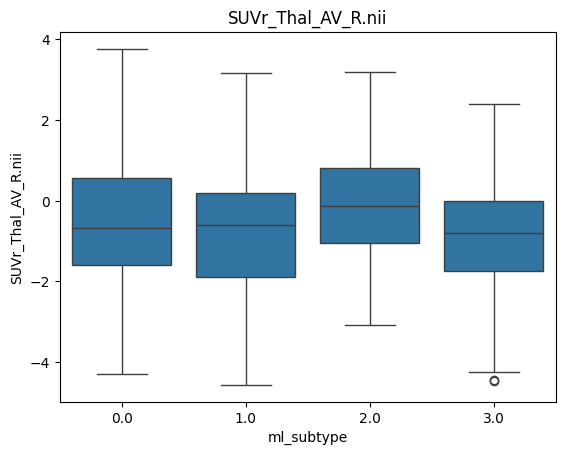

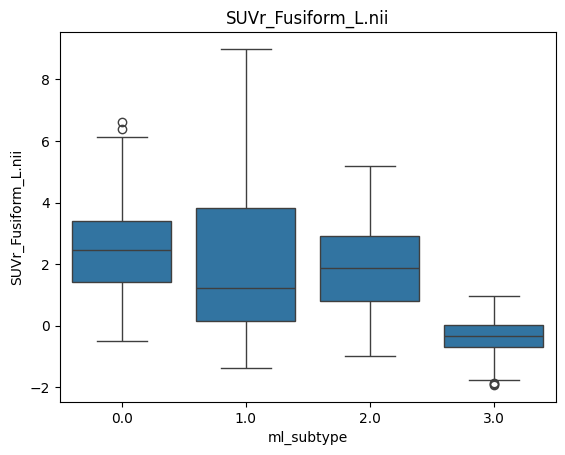

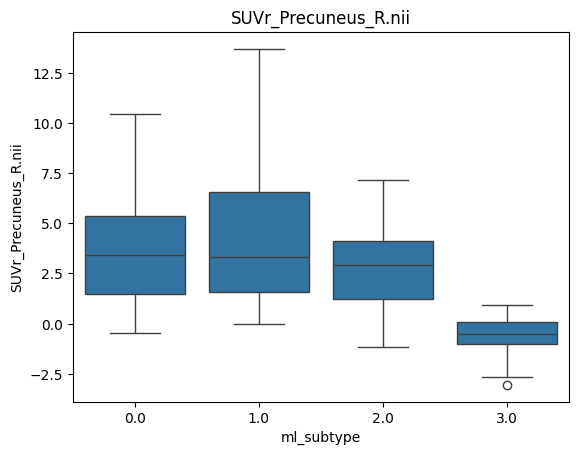

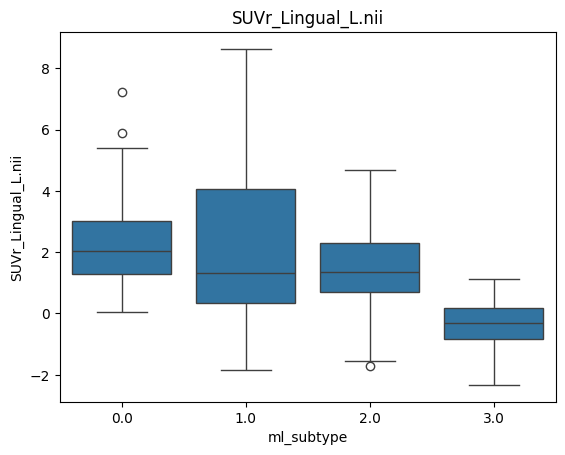

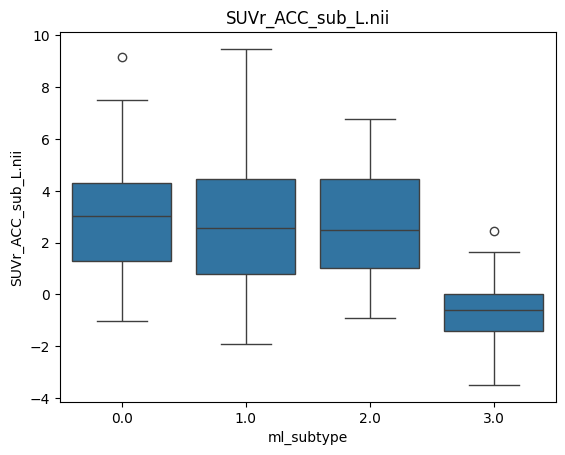

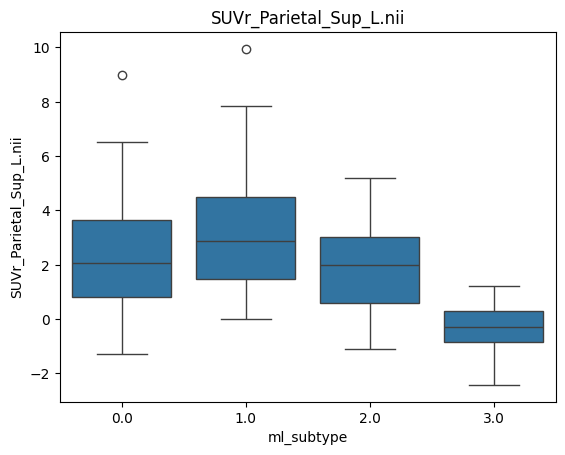

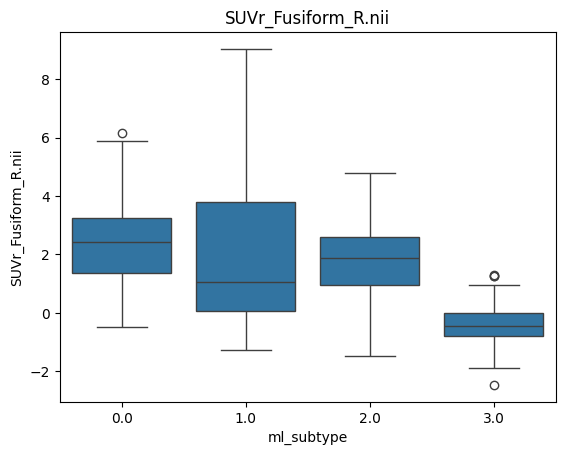

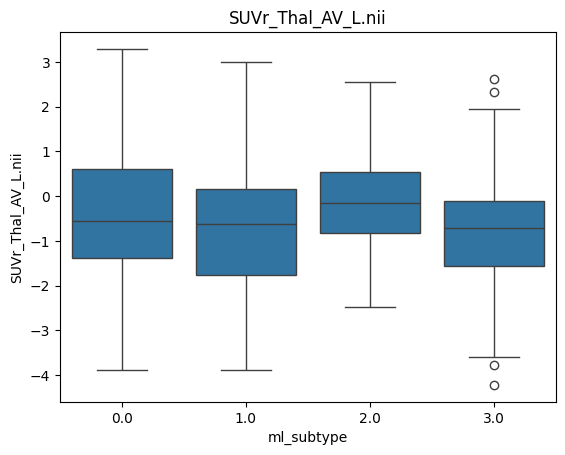

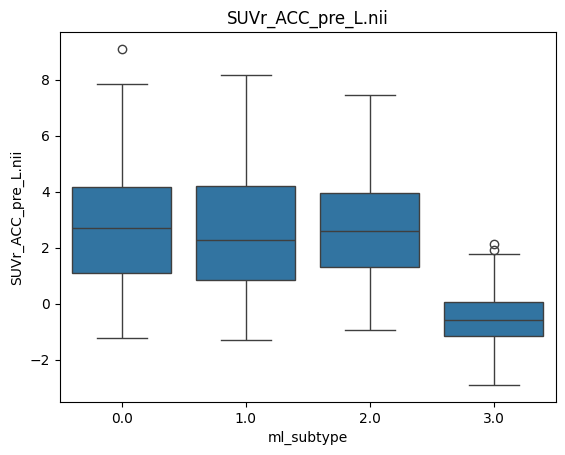

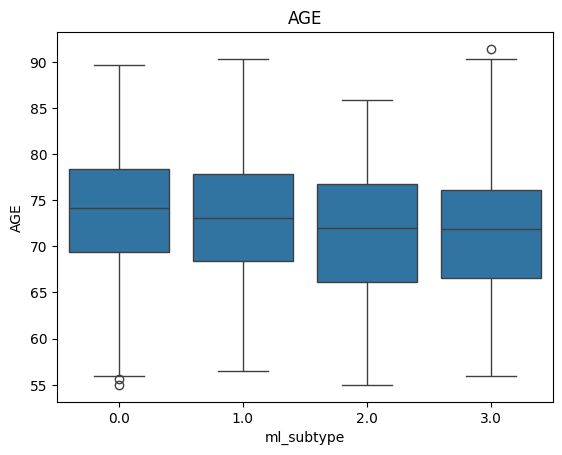

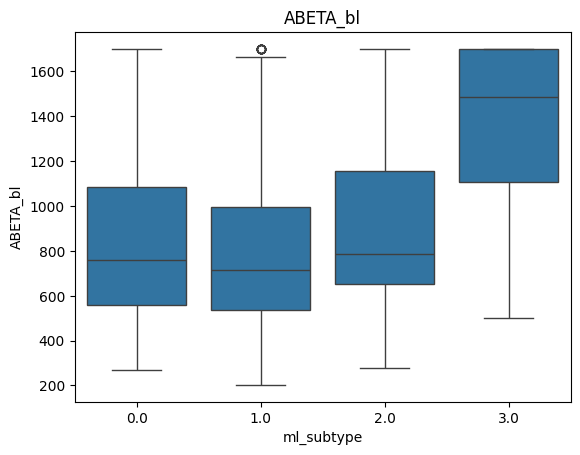

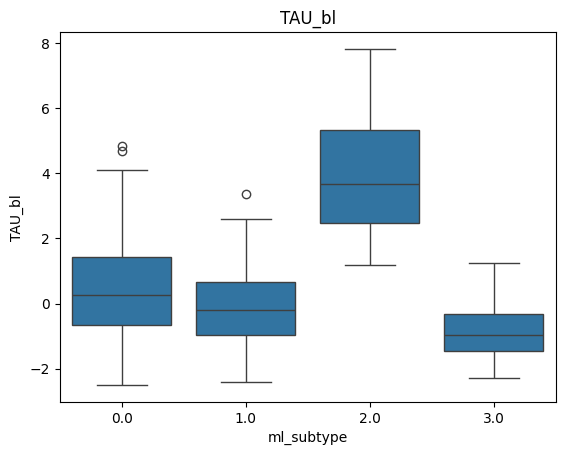

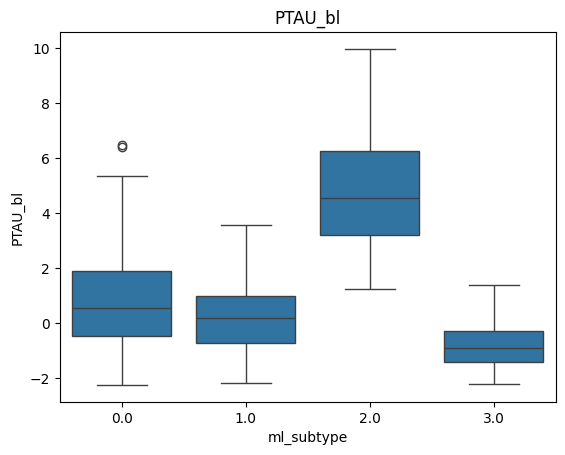

In [223]:
features = ['SUVr_Precuneus_L.nii',
 'SUVr_Thal_AV_R.nii',
 'SUVr_Fusiform_L.nii',
 'SUVr_Precuneus_R.nii',
 'SUVr_Lingual_L.nii',
 'SUVr_ACC_sub_L.nii',
 'SUVr_Parietal_Sup_L.nii',
 'SUVr_Fusiform_R.nii',
 'SUVr_Thal_AV_L.nii',
 'SUVr_ACC_pre_L.nii',
 'AGE',
 'ABETA_bl',
 'TAU_bl',
 'PTAU_bl']

for i in features:
    plt.title(label = i)
    sns.boxplot(data = zdata, x = 'ml_subtype', y = i)
    plt.show()

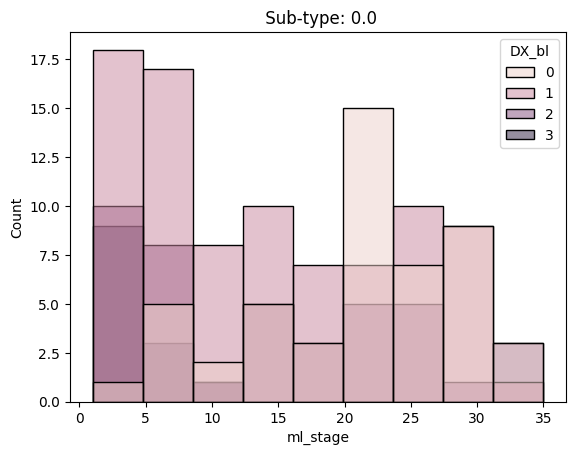

DX_bl     0  1  2  3
ml_stage            
1.0       0  7  4  3
2.0       0  6  2  4
3.0       1  3  1  1
4.0       0  2  3  1
5.0       0  8  4  3
6.0       2  5  3  0
7.0       2  3  1  0
8.0       1  1  0  0
9.0       1  1  0  0
10.0      0  0  0  1
11.0      1  3  0  0
12.0      0  4  1  0
13.0      1  0  3  0
14.0      1  4  1  0
15.0      0  2  1  0
16.0      3  4  0  0
17.0      1  3  1  0
18.0      1  1  1  0
19.0      1  3  1  0
20.0      5  1  0  0
21.0      3  2  3  0
22.0      3  3  0  0
23.0      4  1  2  0
24.0      1  2  3  0
25.0      2  3  2  0
26.0      2  2  0  0
27.0      2  3  0  0
28.0      4  2  0  0
29.0      1  1  0  0
30.0      1  4  0  0
31.0      3  2  1  0
32.0      2  1  2  0
34.0      1  0  0  0
35.0      0  0  1  0


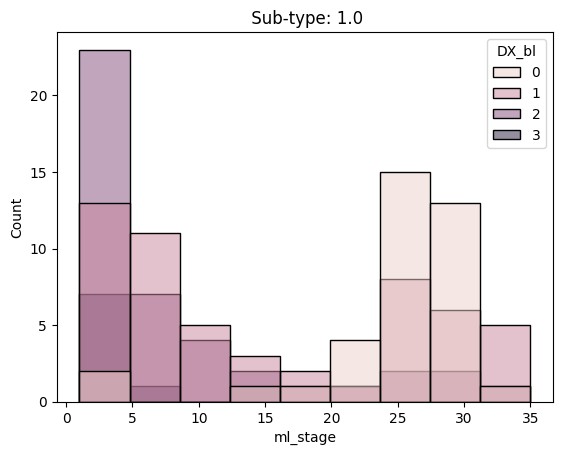

DX_bl      0  1  2  3
ml_stage             
1.0        0  4  7  3
2.0        0  4  4  1
3.0        0  3  7  3
4.0        2  2  5  0
5.0        0  4  2  1
6.0        0  0  2  0
7.0        0  5  2  0
8.0        0  2  1  0
9.0        0  2  0  0
10.0       0  1  2  0
11.0       0  2  2  0
13.0       1  0  1  1
14.0       0  0  1  0
15.0       0  2  0  0
16.0       0  1  0  0
17.0       1  0  0  0
18.0       0  2  1  0
21.0       2  0  1  0
22.0       0  1  0  0
23.0       2  0  0  0
24.0       3  1  1  0
25.0       9  6  0  0
26.0       3  0  0  0
27.0       0  1  1  0
28.0       3  0  0  0
29.0      10  5  1  0
30.0       0  1  1  0
32.0       1  2  0  0
33.0       0  3  0  0
35.0       0  0  1  0


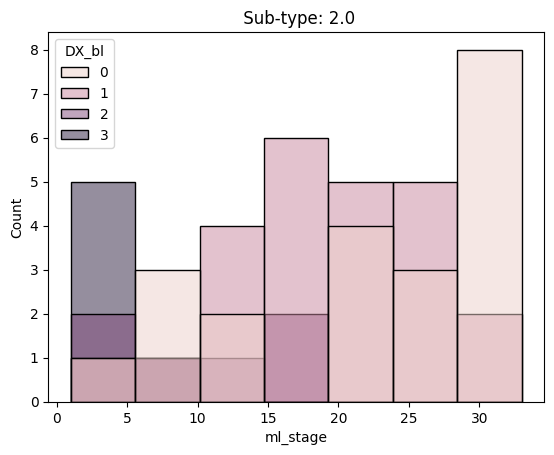

DX_bl     0  1  2  3
ml_stage            
1.0       0  0  1  4
3.0       1  0  1  1
5.0       0  1  0  0
6.0       1  0  0  1
8.0       1  0  0  0
9.0       1  0  1  0
10.0      0  1  0  0
11.0      1  1  0  0
12.0      1  2  0  0
13.0      0  1  0  0
14.0      0  0  1  0
15.0      0  0  1  0
17.0      0  2  0  0
18.0      0  2  0  0
19.0      0  2  1  0
20.0      0  3  0  0
21.0      1  0  0  0
22.0      1  1  0  0
23.0      2  1  0  0
25.0      1  1  0  0
26.0      0  2  0  0
28.0      2  2  0  0
29.0      2  0  0  0
30.0      2  0  0  0
31.0      4  1  0  0
33.0      0  1  0  0


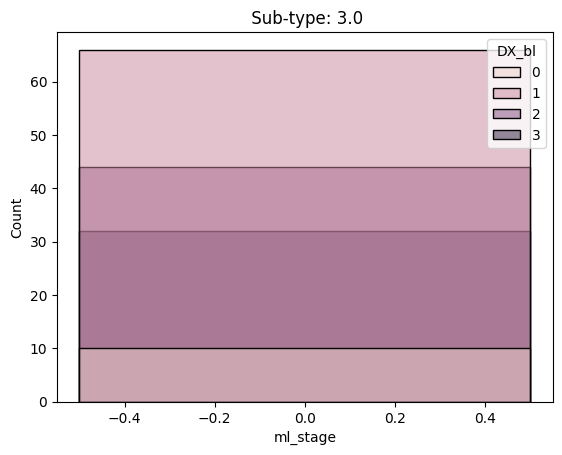

DX_bl      0   1   2   3
ml_stage                
0.0       10  66  44  32


In [224]:
subtype = [0.0,1.0,2.0,3.0]
for i in subtype:
    temp_df = zdata[zdata['ml_subtype']==i]
    plt.title(f" Sub-type: {i}")
    sns.histplot(zdata[zdata['ml_subtype'] == i], x = 'ml_stage', hue='DX_bl')
    plt.show()
    print(pd.crosstab(temp_df['ml_stage'], zdata['DX_bl']))


<Axes: xlabel='ml_subtype', ylabel='count'>

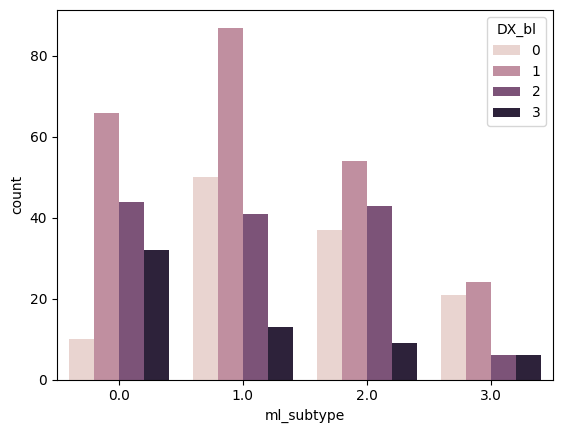

In [124]:
sns.countplot(x='ml_subtype', hue='DX_bl', data=zdata)


In [68]:
# choose the number of folds - here i've used three for speed but i recommend 10 typically
N_folds = 3

# generate stratified cross-validation training and test set splits
labels = zdata.DX_bl.values
cv = sklearn.model_selection.StratifiedKFold(n_splits=N_folds, shuffle=True)
cv_it = cv.split(zdata, labels)

# SuStaIn currently accepts ragged arrays, which will raise problems in the future.
# We'll have to update this in the future, but this will have to do for now
test_idxs = []
for train, test in cv_it:
    test_idxs.append(test)
test_idxs = np.array(test_idxs,dtype='int')

In [69]:
CVIC, loglike_matrix     = sustain_input.cross_validate_sustain_model(test_idxs)


Folds:   0%|          | 0/3 [00:00<?, ?it/s]

Finding ML solution to 1 cluster problem
Overall ML likelihood is -7415.812609124256


MCMC Iteration: 100%|██████████| 10000/10000 [00:24<00:00, 406.02it/s]


Splitting cluster 1 of 1
 + Resolving 2 cluster problem
 + Finding ML solution from hierarchical initialisation
- ML likelihood is [-7357.32395388]
Overall ML likelihood is [-7357.32395388]


MCMC Iteration: 100%|██████████| 10000/10000 [00:48<00:00, 204.36it/s]


Splitting cluster 1 of 2
 + Resolving 2 cluster problem
 + Finding ML solution from hierarchical initialisation
- ML likelihood is [-7349.88597564]
Splitting cluster 2 of 2
 + Resolving 2 cluster problem
 + Finding ML solution from hierarchical initialisation
- ML likelihood is [-7349.22367991]
Overall ML likelihood is [-7349.22367991]


Folds:  33%|███▎      | 1/3 [21:53<43:46, 1313.05s/it]

Finding ML solution to 1 cluster problem
Overall ML likelihood is -7328.6977533816225


MCMC Iteration: 100%|██████████| 10000/10000 [00:18<00:00, 547.10it/s]


Splitting cluster 1 of 1
 + Resolving 2 cluster problem
 + Finding ML solution from hierarchical initialisation
- ML likelihood is [-7272.07244289]
Overall ML likelihood is [-7272.07244289]


MCMC Iteration: 100%|██████████| 10000/10000 [00:40<00:00, 244.40it/s]


Splitting cluster 1 of 2
 + Resolving 2 cluster problem
 + Finding ML solution from hierarchical initialisation
- ML likelihood is [-7256.57382594]
Splitting cluster 2 of 2
 + Resolving 2 cluster problem
 + Finding ML solution from hierarchical initialisation
- ML likelihood is [-7255.87250501]
Overall ML likelihood is [-7255.87250501]


Folds:  67%|██████▋   | 2/3 [45:38<22:59, 1379.14s/it]

Finding ML solution to 1 cluster problem
Overall ML likelihood is -7535.099898356263


MCMC Iteration: 100%|██████████| 10000/10000 [00:17<00:00, 566.14it/s]


Splitting cluster 1 of 1
 + Resolving 2 cluster problem
 + Finding ML solution from hierarchical initialisation
- ML likelihood is [-7485.81787621]
Overall ML likelihood is [-7485.81787621]


MCMC Iteration: 100%|██████████| 10000/10000 [00:39<00:00, 255.78it/s]


Splitting cluster 1 of 2
 + Resolving 2 cluster problem
 + Finding ML solution from hierarchical initialisation
- ML likelihood is [-7465.36810026]
Splitting cluster 2 of 2
 + Resolving 2 cluster problem
 + Finding ML solution from hierarchical initialisation
- ML likelihood is [-7465.28967255]
Overall ML likelihood is [-7465.28967255]


Folds: 100%|██████████| 3/3 [1:08:38<00:00, 1372.94s/it]

Average test set log-likelihood for each subtype model: [-3724.31054685 -3702.75587006 -3695.92967923]
CVIC for each subtype model: [22320.43935561 22191.95487476 22144.93736359]


CVIC for each subtype model: [22320.43935561 22191.95487476 22144.93736359]
Average test set log-likelihood for each subtype model: [-3724.31054685 -3702.75587006 -3695.92967923]


Text(0.5, 1.0, 'Test set log-likelihood across folds')

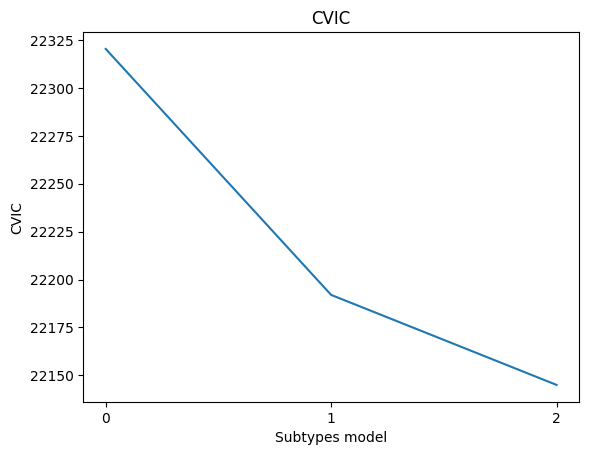

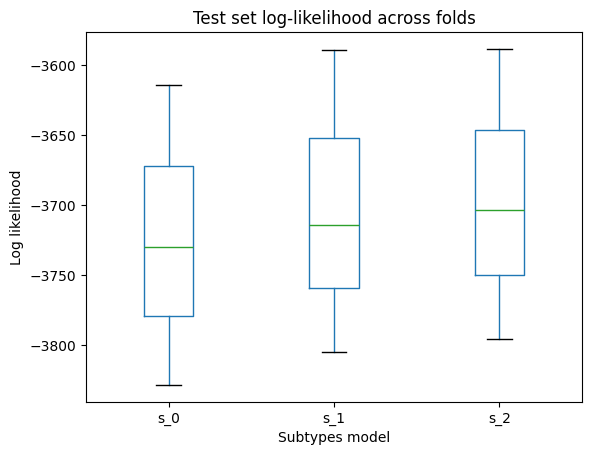

In [70]:
# go through each subtypes model and plot the log-likelihood on the test set and the CVIC
print("CVIC for each subtype model: " + str(CVIC))
print("Average test set log-likelihood for each subtype model: " + str(np.mean(loglike_matrix, 0)))

plt.figure(0)    
plt.plot(np.arange(N_S_max,dtype=int),CVIC)
plt.xticks(np.arange(N_S_max,dtype=int))
plt.ylabel('CVIC')  
plt.xlabel('Subtypes model') 
plt.title('CVIC')

plt.figure(1)
df_loglike = pd.DataFrame(data = loglike_matrix, columns = ["s_" + str(i) for i in range(sustain_input.N_S_max)])
df_loglike.boxplot(grid=False)
plt.ylabel('Log likelihood')  
plt.xlabel('Subtypes model') 
plt.title('Test set log-likelihood across folds')

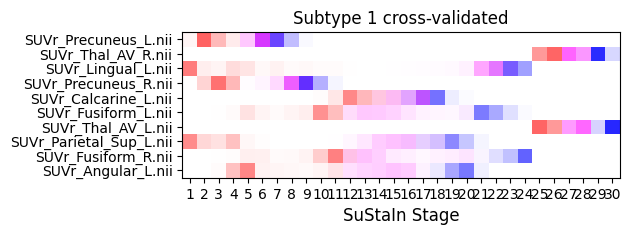

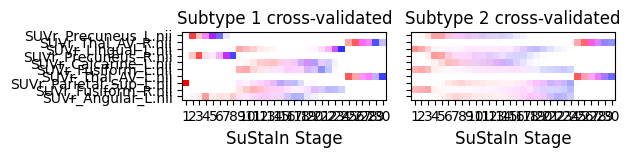

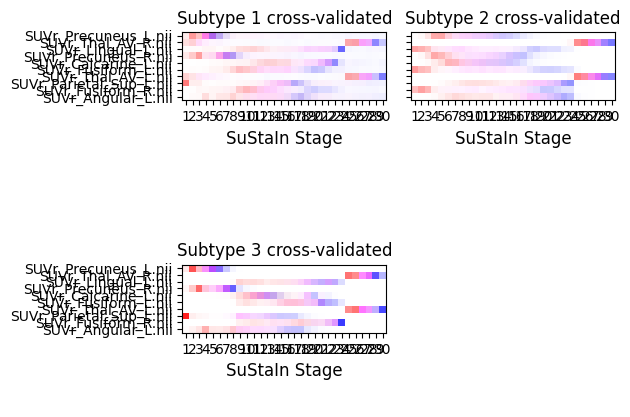

In [71]:
for i in range(N_S_max):
    sustain_input.combine_cross_validated_sequences(i+1, N_folds)

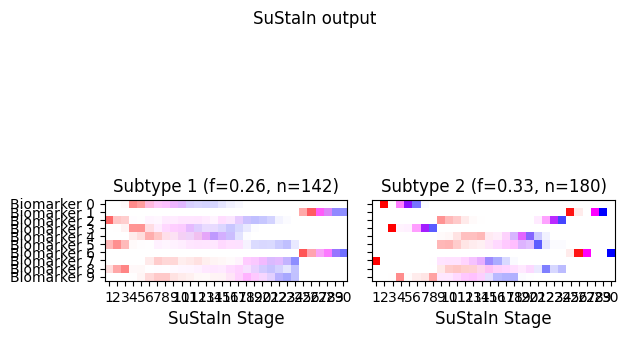

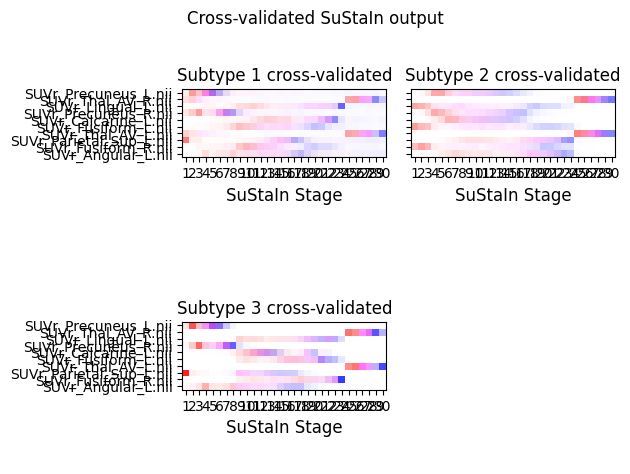

In [75]:
N_S_selected = 3

ZscoreSustain._plot_sustain_model(sustain_input,samples_sequence,samples_f,M,subtype_order=(0,1))
_ = plt.suptitle('SuStaIn output')

sustain_input.combine_cross_validated_sequences(N_S_selected, N_folds)
_ = plt.suptitle('Cross-validated SuStaIn output')

In [125]:
zdata[zdata['ml_subtype'] == 1.0]

,PTID,TAU_bl,PTAU_bl,ABETA_bl,EXAMDATE,EXAMDATE_bl,DX_bl,DX,AGE,PTGENDER,...,SUVr_Vermis_9.nii,SUVr_Vermis_10.nii,SUVr_VTA_L.nii,SUVr_VTA_R.nii,ml_subtype,prob_ml_subtype,ml_stage,prob_ml_stage,prob_S0,prob_S1
3,135_S_5275,2.986599,4.308707,832.7,2014-02-25,2013-08-27,0,0,78.0,1,...,-1.058055,-1.043347,-0.071741,0.279041,1.0,0.902705,30.0,0.339371,0.902705,0.070157
5,007_S_5265,-0.276825,0.180860,466.1,2015-08-25,2013-08-12,2,2,75.1,1,...,-0.164410,-1.866826,-1.578615,-0.821609,1.0,0.554092,4.0,0.083731,0.554092,0.430943
6,032_S_5263,2.519820,4.177895,684.4,2016-01-05,2013-10-07,2,2,75.2,1,...,0.967609,0.966878,-0.210845,-0.909640,1.0,0.901862,32.0,0.361589,0.901862,0.097906
8,130_S_5258,0.100085,0.404694,869.7,2015-08-11,2013-08-12,2,2,77.9,1,...,-1.273849,-1.321389,-1.435085,-1.750964,1.0,0.764574,13.0,0.105684,0.764574,0.235425
12,041_S_5244,-1.430358,-1.294410,1681.0,2015-08-05,2013-07-31,2,2,75.8,1,...,2.146802,1.709017,-0.022676,-0.078511,1.0,0.912690,5.0,0.204869,0.912690,0.087273
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
520,022_S_5004,-0.524969,-0.657791,1700.0,2014-11-14,2012-11-13,1,1,64.6,0,...,2.710280,0.744128,1.024333,0.551319,1.0,0.816219,1.0,0.197191,0.816219,0.158264
528,135_S_5113,-0.763723,-0.855463,1700.0,2015-04-15,2013-04-15,3,2,65.1,0,...,-0.454308,-0.430341,0.404351,0.426903,1.0,0.986312,5.0,0.237068,0.986312,0.013547
531,041_S_5141,-0.722143,-0.721744,1700.0,2015-07-02,2013-04-30,3,2,76.7,0,...,-0.114895,-0.287621,0.559916,0.484503,1.0,0.792381,2.0,0.172377,0.792381,0.197304
542,127_S_5266,0.163126,0.108186,1700.0,2015-08-06,2013-08-15,3,2,65.9,0,...,1.225569,1.640913,0.089042,0.328973,1.0,0.938403,2.0,0.213208,0.938403,0.040201
